<a href="https://colab.research.google.com/github/AishwaryaSukumaran/Final-Project_22058088/blob/main/energy_data_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title: Time Series Analysis and SARIMA Modeling of Household Energy Consumption

**Introduction:**

1. Electricity is essential for powering homes, businesses, and industries in modern life.

2. Household electricity consumption in France forms a significant part of overall energy use.

3. Key influencing factors:
      * Seasonal changes (e.g., winter heating, summer cooling).
      * Daily routines (e.g., morning and evening peaks).
      * Technology adoption (e.g., smart meters, electric vehicles).
      * Social behaviors (e.g., festive activities, vacations).

**Objectives:**

1. Understand Energy Patterns: Identify seasonal and daily electricity consumption trends in French households.

2. Forecast Energy Usage: Use the SARIMA model to predict electricity demand during peak and off-peak periods.

3. Evaluate Model Performance: Assess the SARIMA model's accuracy using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

4. Propose Practical Strategies: Develop recommendations for households to reduce energy costs and for providers to improve grid management.

**Methodology:**

1. Data Collection: The dataset, sourced from the UCI Machine Learning Repository, records minute-level electricity usage for a single household over four years. Key features include global active power, voltage, and sub-metering data for different household zones.

2. Data Preprocessing: Missing values are handled, and the dataset is aggregated into daily, weekly, and monthly levels to identify trends and seasonal patterns.

3. Exploratory Data Analysis (EDA): Visualizations such as line charts and bar graphs are used to uncover energy consumption trends and seasonal variations.

4. Time Series Decomposition: STL decomposition is applied to break down electricity usage into trend, seasonal, and residual components.

5. SARIMA Modeling: Weekly and monthly SARIMA models are developed to forecast electricity usage. The model's performance is evaluated using residual analysis and diagnostic tools like ACF and PACF.

6. Forecasting and Insights: Forecasts are used to predict future demand patterns, and insights are generated to help households and energy providers optimize energy use.

### 1. Importing Libraries





In [14]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import statsmodels.api as sm  # For statistical and time series modeling
import numpy as np  # For numerical computations
import warnings  # To handle warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning  # To handle specific warnings related to model convergence
from statsmodels.tsa.seasonal import STL  # For seasonal-trend decomposition using LOESS
from statsmodels.tsa.statespace.sarimax import SARIMAX  # For SARIMA modeling
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For model evaluation metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For plotting autocorrelation and partial autocorrelation functions

# Comments for each:
# 1. `pandas` is used to load, manipulate, and preprocess datasets.
# 2. `matplotlib.pyplot` is used for plotting graphs and visualizing data trends.
# 3. `statsmodels.api` is the main library for statistical analysis and modeling.
# 4. `numpy` provides support for numerical operations on arrays and matrices.
# 5. `warnings` is used to suppress unnecessary warnings for cleaner output.
# 6. `ConvergenceWarning` specifically handles warnings when a model fails to converge.
# 7. `STL` is used to decompose a time series into seasonal, trend, and residual components.
# 8. `SARIMAX` extends ARIMA models to handle seasonality
# 9. `mean_absolute_error` and `mean_squared_error` are metrics to evaluate model performance.
# 10. `plot_acf` and `plot_pacf` are used to examine lags in the time series to determine the ARIMA order.


2. Data Loading and Preprocessing

In [15]:
# Step 1: Load and preprocess the data
def load_and_preprocess_energy_data(filepath):
    # Load the dataset with specified parameters:
    # 'sep' specifies the delimiter (';' in this case).
    # 'na_values' treats specific values ('nan', '?') as missing.
    # 'low_memory' is set to False to prevent mixed data types during loading.
    energy_data = pd.read_csv(filepath, sep=';', na_values=['nan', '?'], low_memory=False)

    # Combine 'Date' and 'Time' columns into a single 'Datetime' column.
    # 'dayfirst=True' ensures dates are parsed in day-first format (DD/MM/YYYY).
    energy_data['Datetime'] = pd.to_datetime(energy_data['Date'] + ' ' + energy_data['Time'], dayfirst=True)

    # Set 'Datetime' as the index of the DataFrame for time series operations.
    energy_data.set_index('Datetime', inplace=True)

    # Remove the now redundant 'Date' and 'Time' columns.
    energy_data.drop(['Date', 'Time'], axis=1, inplace=True)

    # Convert the 'Global_active_power' column to numeric.
    # Invalid parsing will be set to NaN (due to 'errors="coerce"').
    energy_data['Global_active_power'] = pd.to_numeric(energy_data['Global_active_power'], errors='coerce')

    # Drop rows with missing values to clean the dataset.
    energy_data.dropna(inplace=True)

    # Return the cleaned dataset.
    return energy_data

# Path to the dataset
energy_data_filepath = '/content/drive/MyDrive/Final Project/household_power_consumption.txt'
# Call the preprocessing function to load and preprocess the data.
energy_data = load_and_preprocess_energy_data(energy_data_filepath)

# Filter data for the years 2007 to 2010
# Select data where the 'Datetime' index falls within the specified range.
filtered_energy_data = energy_data[(energy_data.index >= '2007-01-01') & (energy_data.index <= '2010-12-31')]

# Display a random sample of 10 rows from the cleaned dataset
# Label the output for clarity.
print("\nRandom Sample of the Dataset:")

# Use 'display' to show a sample of 10 random rows from the dataset.
# Apply custom table styles for better presentation.
display(energy_data.sample(10).style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]  # Add borders and padding to table cells.
))



Random Sample of the Dataset:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2009-10-27 02:59:00,0.394000,0.226000,244.500000,1.800000,0.000000,1.000000,1.000000
2007-07-28 10:46:00,0.500000,0.180000,234.110000,3.200000,0.000000,0.000000,0.000000
2009-07-11 08:06:00,0.350000,0.106000,240.870000,1.600000,0.000000,2.000000,1.000000
2010-02-28 09:46:00,0.500000,0.064000,240.900000,2.000000,0.000000,0.000000,1.000000
2007-03-18 03:15:00,0.234000,0.000000,246.120000,1.000000,0.000000,0.000000,0.000000
2010-09-23 19:59:00,0.884000,0.000000,241.580000,3.600000,0.000000,2.000000,1.000000
2009-11-27 19:36:00,2.450000,0.198000,238.790000,10.200000,0.000000,0.000000,11.000000
2007-04-30 21:57:00,0.602000,0.118000,233.130000,2.600000,1.000000,0.000000,0.000000
2009-12-01 07:10:00,2.164000,0.000000,242.260000,8.800000,0.000000,0.000000,19.000000


3. Exploratory Data Analysis (EDA)

3.1 Analyze Weekly, Monthly, and Yearly Energy Usage

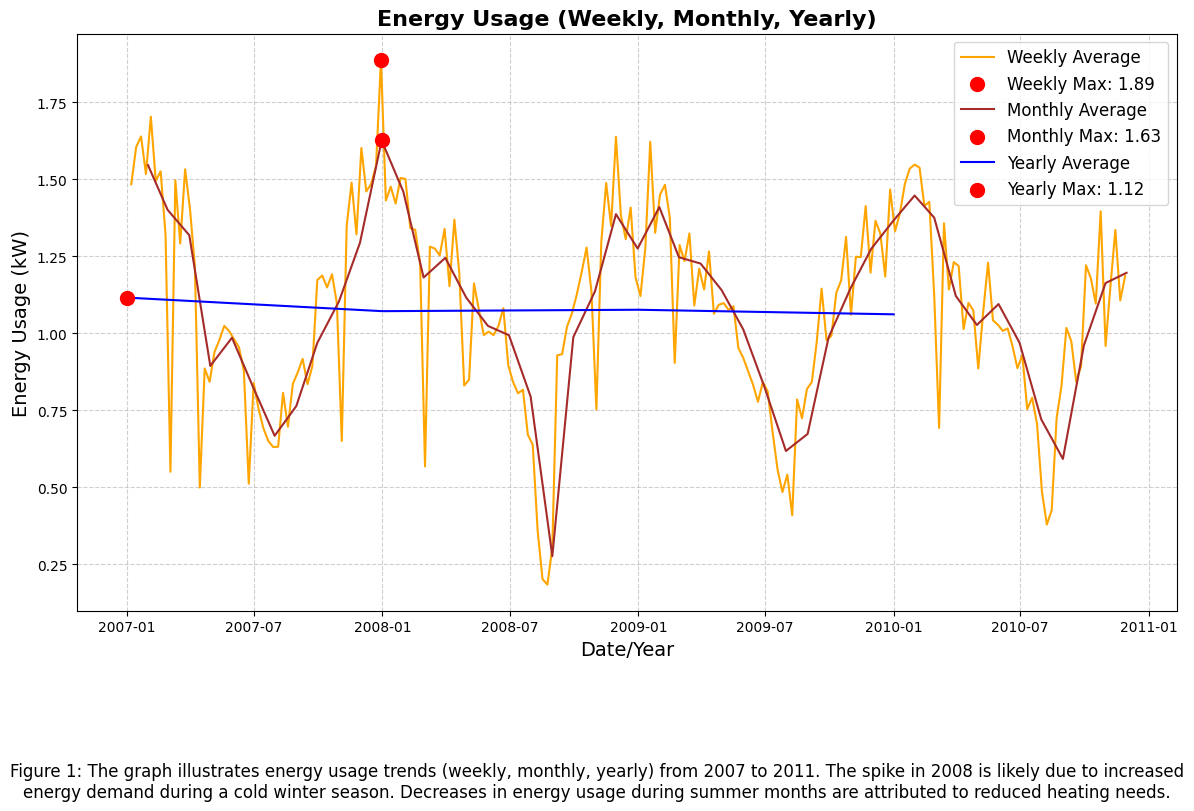

In [16]:
# Step 2: Combined and Maximum Value Visualization

# Resample the data to calculate daily mean energy usage
daily_energy_mean = filtered_energy_data['Global_active_power'].resample('D').mean()
# Calculates the mean energy usage for each day by resampling the data with daily frequency.

# Resample the daily data to calculate weekly mean energy usage
weekly_energy_mean = daily_energy_mean.resample('W').mean()
# Aggregates the daily mean energy usage into weekly averages using the weekly frequency.

# Resample the daily data to calculate monthly mean energy usage
monthly_energy_mean = daily_energy_mean.resample('ME').mean()  # 'ME' ensures month-end alignment
# Aggregates daily mean energy usage into monthly averages, ensuring alignment to the month-end.

# Resample the daily data to calculate yearly mean energy usage
yearly_energy_mean = daily_energy_mean.resample('YE').mean()  # 'YE' ensures year-end alignment
# Aggregates daily mean energy usage into yearly averages, ensuring alignment to the year-end.

# Simplify yearly index to show only the year (e.g., 2007, 2008) instead of full datetime
yearly_energy_mean.index = yearly_energy_mean.index.year
# Converts the yearly index from full datetime format to just the year for cleaner visualization.

# Define a function to plot combined energy usage for weekly, monthly, and yearly data
def plot_combined_energy_usage_with_explanation(weekly_data, monthly_data, yearly_data):
    # Initializes a figure and axes for the plot with a specified size.
    fig, ax = plt.subplots(figsize=(12, 8))

    # Find the maximum value and corresponding date for weekly data
    max_weekly = weekly_data.max()
    max_weekly_date = weekly_data.idxmax()  # Index of the maximum value
    # Determines the maximum weekly energy usage and the date it occurred.

    # Plot the weekly average energy usage
    ax.plot(weekly_data.index, weekly_data, color='orange', label='Weekly Average')
    # Plots the weekly average energy usage as an orange line.

    # Highlight the maximum point on the weekly data
    ax.scatter(max_weekly_date, max_weekly, color='red', s=100, zorder=5, label=f"Weekly Max: {max_weekly:.2f}")
    # Marks the maximum weekly usage with a red dot and adds a label.

    # Find the maximum value and corresponding date for monthly data
    max_monthly = monthly_data.max()
    max_monthly_date = monthly_data.idxmax()  # Index of the maximum value
    # Determines the maximum monthly energy usage and the date it occurred.

    # Plot the monthly average energy usage
    ax.plot(monthly_data.index, monthly_data, color='brown', label='Monthly Average')
    # Plots the monthly average energy usage as a brown line.

    # Highlight the maximum point on the monthly data
    ax.scatter(max_monthly_date, max_monthly, color='red', s=100, zorder=5, label=f"Monthly Max: {max_monthly:.2f}")
    # Marks the maximum monthly usage with a red dot and adds a label.

    # Find the maximum value and corresponding year for yearly data
    max_yearly = yearly_data.max()
    max_yearly_date = yearly_data.idxmax()  # Index of the maximum value
    # Determines the maximum yearly energy usage and the year it occurred.

    # Plot the yearly average energy usage
    ax.plot(pd.to_datetime(yearly_data.index, format='%Y'), yearly_data, color='blue', label='Yearly Average')
    # Plots the yearly average energy usage as a blue line. Converts the yearly index back to datetime for plotting.

    # Highlight the maximum point on the yearly data
    ax.scatter(pd.to_datetime(max_yearly_date, format='%Y'), max_yearly, color='red', s=100, zorder=5, label=f"Yearly Max: {max_yearly:.2f}")
    # Marks the maximum yearly usage with a red dot and adds a label.

    # Set the title of the plot with a larger font size and bold text
    ax.set_title('Energy Usage (Weekly, Monthly, Yearly)', fontsize=16, fontweight='bold')
    # Sets the title of the graph.

    # Label the x-axis with a descriptive title and adjust the font size
    ax.set_xlabel('Date/Year', fontsize=14)
    # Sets the label for the x-axis.

    # Label the y-axis with a descriptive title and adjust the font size
    ax.set_ylabel('Energy Usage (kW)', fontsize=14)
    # Sets the label for the y-axis.

    # Add a legend to the plot with a specific font size
    ax.legend(fontsize=12)
    # Adds a legend for the lines and points plotted.

    # Add a grid to the plot with dashed lines and reduced opacity for clarity
    ax.grid(True, linestyle='--', alpha=0.6)
    # Adds a grid for better readability of the graph.

    # Add explanation below the figure as a paragraph
    plt.figtext(
        0.5, -0.05,
        "Figure 1: The graph illustrates energy usage trends (weekly, monthly, yearly) from 2007 to 2011. "
        "The spike in 2008 is likely due to increased energy demand during a cold winter season. "
        "Decreases in energy usage during summer months are attributed to reduced heating needs.",
        wrap=True, horizontalalignment='center', fontsize=12
    )
    # Adds a descriptive caption below the plot.

    # Adjust the layout to ensure no overlapping of elements
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    # Ensures the layout of the plot is tidy and all elements fit within the figure.

    # Display the plot
    plt.show()
    # Renders the plot for viewing.

# Call the function to plot the combined energy usage
plot_combined_energy_usage_with_explanation(weekly_energy_mean, monthly_energy_mean, yearly_energy_mean)
# Calls the function with the resampled weekly, monthly, and yearly data to generate the plot.



3.2 Seasonal Energy Usage Analysis Trends


Random Sample of the Dataset:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Season
Datetime,,,,,,,,
2009-11-16 14:09:00,0.296000,0.086000,244.820000,1.200000,0.000000,0.000000,1.000000,Autumn
2008-03-30 12:05:00,1.992000,0.090000,235.780000,8.400000,0.000000,1.000000,17.000000,Spring
2007-06-09 00:38:00,0.346000,0.162000,243.520000,1.400000,0.000000,0.000000,0.000000,Summer
2007-06-09 09:15:00,1.354000,0.046000,237.910000,5.600000,0.000000,0.000000,17.000000,Summer
2007-02-03 21:27:00,2.926000,0.220000,238.480000,12.200000,0.000000,0.000000,18.000000,Winter
2010-05-08 14:43:00,1.434000,0.100000,244.420000,5.800000,0.000000,0.000000,19.000000,Spring
2009-12-08 05:48:00,0.330000,0.138000,244.550000,1.400000,0.000000,1.000000,1.000000,Winter
2009-08-02 18:42:00,0.376000,0.150000,240.140000,1.800000,0.000000,0.000000,1.000000,Summer
2008-06-09 16:31:00,0.398000,0.090000,240.330000,1.800000,0.000000,0.000000,0.000000,Summer


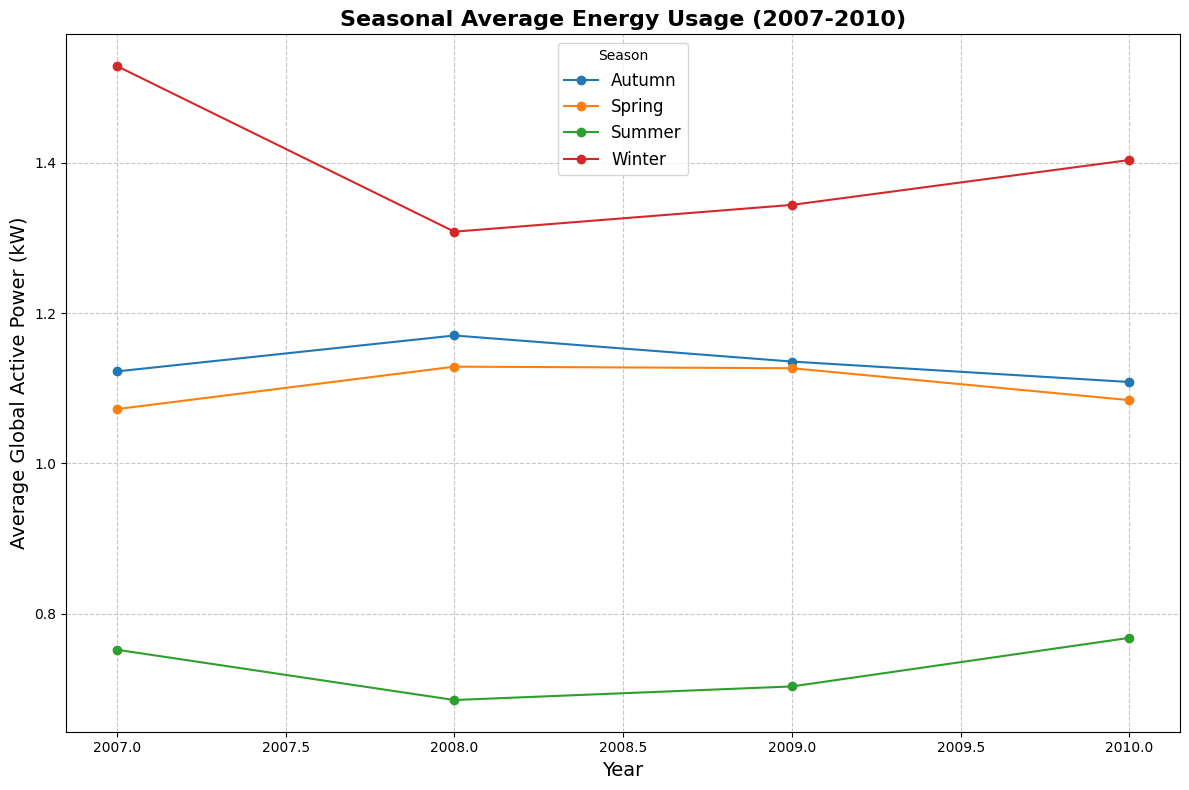

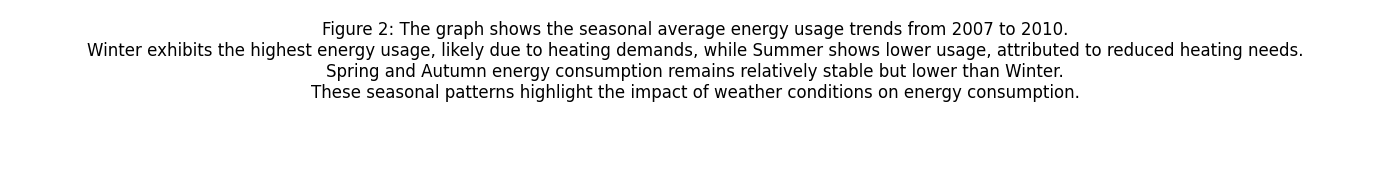

In [17]:
# Step 3: Seasonal Analysis

# Function to determine the season based on the month of a given date
def get_season(date):
    month = date.month  # Extract the month from the date
    # Checks the month value and assigns a season accordingly.
    if month in [12, 1, 2]:  # December, January, February
        return 'Winter'
    elif month in [3, 4, 5]:  # March, April, May
        return 'Spring'
    elif month in [6, 7, 8]:  # June, July, August
        return 'Summer'
    else:  # September, October, November
        return 'Autumn'
# A utility function to classify months into seasons for analysis.

# Make a copy of the filtered data to ensure the original dataset remains unchanged
filtered_energy_data = filtered_energy_data.copy()
# Creates a copy of the dataset to avoid accidental changes to the original data.

# Map the `get_season` function to the index of the dataset to create a new 'Season' column
filtered_energy_data['Season'] = filtered_energy_data.index.map(get_season)
# Applies the `get_season` function to the dataset's index and adds a new column "Season."

# Display a random sample of 10 rows from the modified dataset with the new 'Season' column
print("\nRandom Sample of the Dataset:")  # Print a label for the output
# Provides context for the upcoming data display.
display(filtered_energy_data.sample(10).style.set_table_styles(  # Display the random sample with custom table styles
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]  # Styling for table cells
))
# Displays 10 random rows from the dataset with a styled table for better visualization.

# Group data by year and season, calculating the mean energy usage ('Global_active_power') for each group
seasonal_avg_per_year = filtered_energy_data.groupby(
    [filtered_energy_data.index.year, 'Season']  # Group by year and season
)['Global_active_power'].mean().unstack()  # Unstack to create columns for each season
# Aggregates the dataset to compute the mean energy usage for each season in each year.

# Plot seasonal averages for each year
plt.figure(figsize=(12, 8))  # Set the figure size
# Initializes a figure for plotting with a specified size.

for season in seasonal_avg_per_year.columns:  # Iterate through each season (columns)
    plt.plot(
        seasonal_avg_per_year.index,  # Use the year as the x-axis
        seasonal_avg_per_year[season],  # Use the average energy usage as the y-axis
        label=season,  # Add the season as a label
        marker='o',  # Use circular markers for data points
        linestyle='-'  # Connect points with solid lines
    )
# Plots the seasonal average energy usage for each year using lines and markers, differentiating by season.

# Set the title of the plot with a larger font size and bold text
plt.title('Seasonal Average Energy Usage (2007-2010)', fontsize=16, fontweight='bold')
# Adds a title to the plot.

# Label the x-axis with a descriptive title and adjust the font size
plt.xlabel('Year', fontsize=14)
# Sets the x-axis label to "Year."

# Label the y-axis with a descriptive title and adjust the font size
plt.ylabel('Average Global Active Power (kW)', fontsize=14)
# Sets the y-axis label to describe the plotted data.

# Add a legend to the plot, with a title for the legend and adjusted font size
plt.legend(title='Season', fontsize=12)
# Adds a legend to the plot with a title and adjusted font size.

# Add a grid to the plot with dashed lines and reduced opacity for clarity
plt.grid(True, linestyle='--', alpha=0.7)
# Adds a grid for better readability of the graph.

# Adjust the layout to ensure no overlapping of elements
plt.tight_layout()
# Ensures that all elements fit well within the plot area.

plt.show()
# Displays the plot.

# Figure 2 Description
fig = plt.figure(figsize=(14, 2))
# Creates a new figure with a specified size for adding a description.

fig.text(
    0.5, 0.5,
    "Figure 2: The graph shows the seasonal average energy usage trends from 2007 to 2010.\n"
    "Winter exhibits the highest energy usage, likely due to heating demands, while Summer shows lower usage, attributed to reduced heating needs.\n"
    "Spring and Autumn energy consumption remains relatively stable but lower than Winter.\n"
    "These seasonal patterns highlight the impact of weather conditions on energy consumption.",
    wrap=True, horizontalalignment='center', fontsize=12
)
# Adds a description below the figure to explain the observed trends.

plt.axis('off')
# Hides the axes for the descriptive text figure.

plt.tight_layout()
# Adjusts the layout to ensure the text is well-aligned and not overlapping.

plt.show()
# Displays the descriptive text figure.



4. Time Series Decomposition (STL)

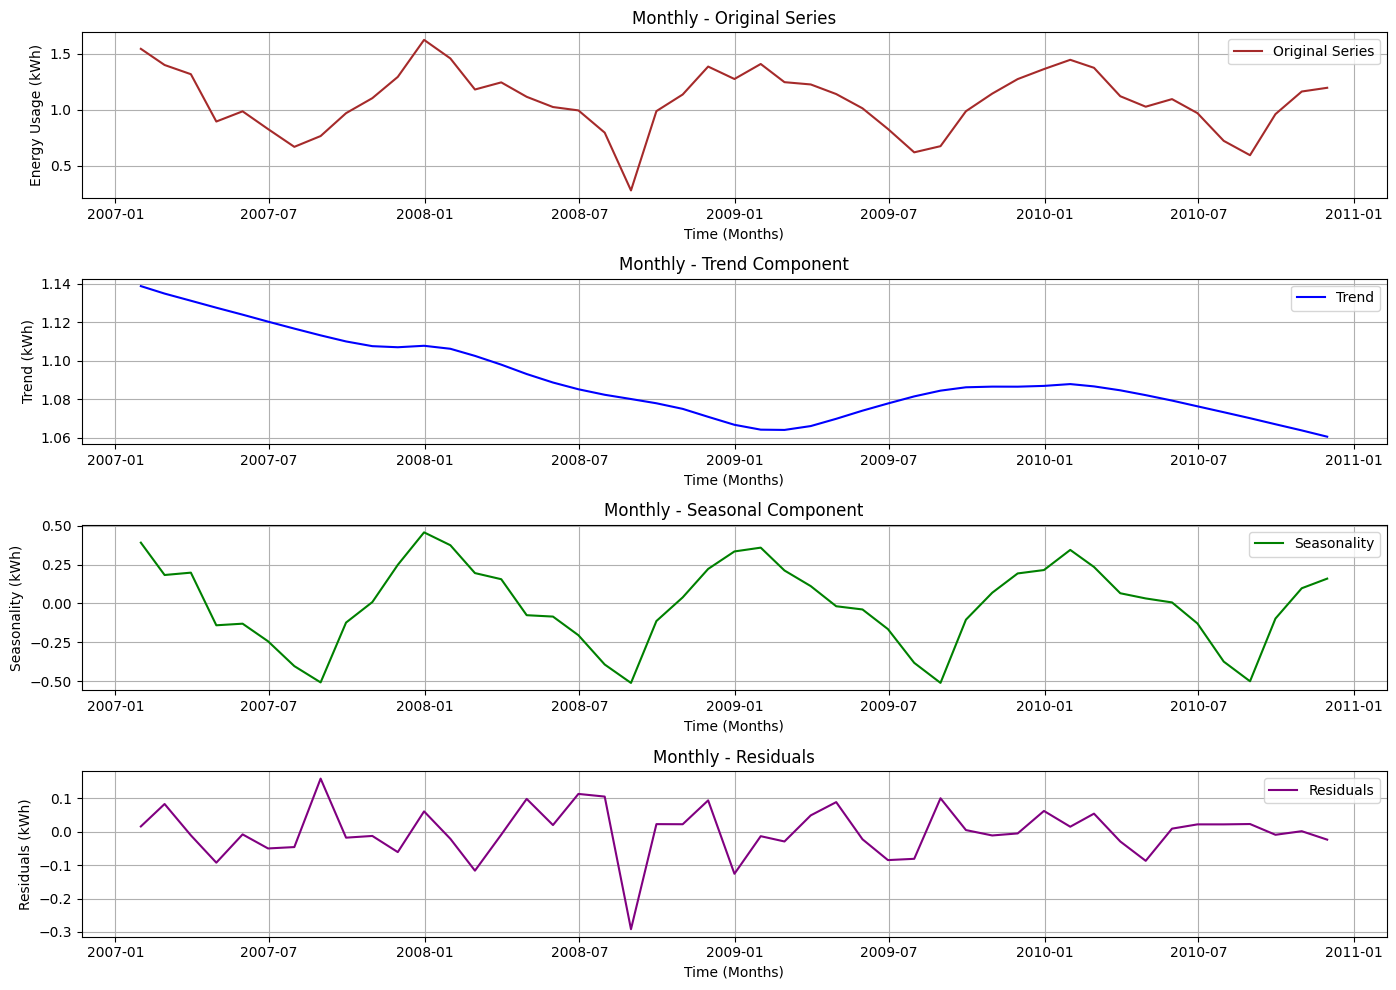

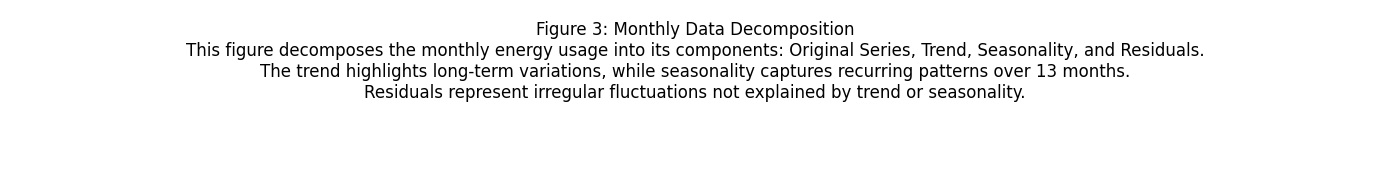

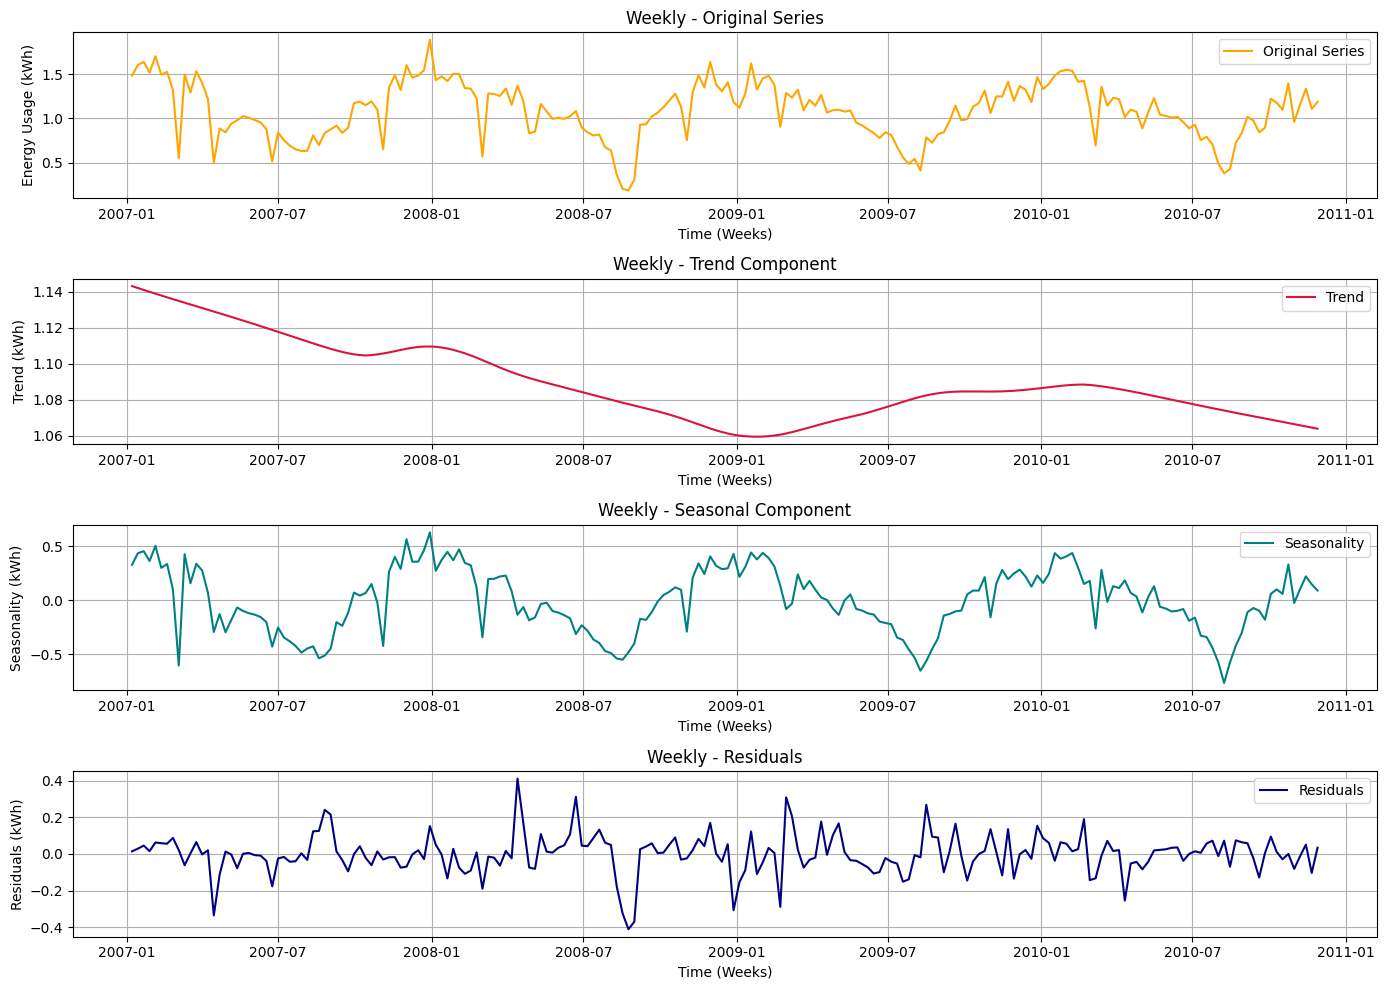

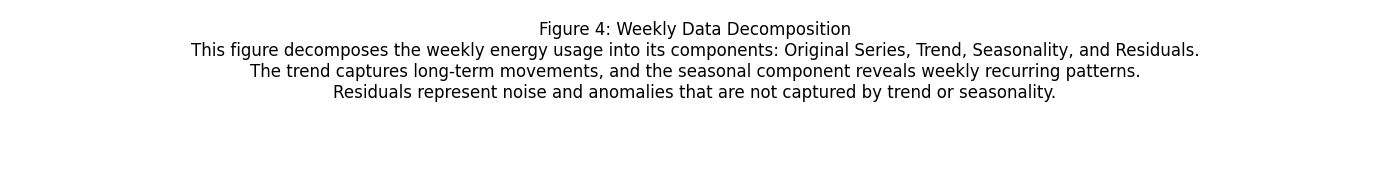

In [18]:

# Suppress warnings
warnings.filterwarnings("ignore")  # Suppress warnings to clean up the output display

# Define colors for consistent styling in the plots
colors = {
    'monthly': {  # Color scheme for monthly data visualization
        'original': 'brown',  # Color for the original series
        'trend': 'blue',  # Color for the trend component
        'seasonality': 'green',  # Color for the seasonality component
        'residuals': 'purple',  # Color for the residuals
    },
    'weekly': {  # Color scheme for weekly data visualization
        'original': 'orange',  # Color for the original series
        'trend': 'Crimson',  # Color for the trend component
        'seasonality': 'teal',  # Color for the seasonality component
        'residuals': 'navy',  # Color for the residuals
    }
}

# STL decomposition for monthly data
stl_monthly = STL(monthly_energy_mean, seasonal=13)  # Apply STL decomposition with 13-month seasonality
stl_result_monthly = stl_monthly.fit()  # Fit the STL model to the monthly data
trend_monthly = stl_result_monthly.trend  # Extract the trend component
seasonal_monthly = stl_result_monthly.seasonal  # Extract the seasonal component
residual_monthly = stl_result_monthly.resid  # Extract the residuals (noise)

# STL decomposition for weekly data
stl_weekly = STL(weekly_energy_mean, seasonal=53)  # Apply STL decomposition with 53-week seasonality
stl_result_weekly = stl_weekly.fit()  # Fit the STL model to the weekly data
trend_weekly = stl_result_weekly.trend  # Extract the trend component
seasonal_weekly = stl_result_weekly.seasonal  # Extract the seasonal component
residual_weekly = stl_result_weekly.resid  # Extract the residuals (noise)

# Plot for monthly data
plt.figure(figsize=(14, 10))  # Set the size of the figure for monthly data visualization

# Original Series
plt.subplot(4, 1, 1)  # Create the first subplot for the original series
plt.plot(monthly_energy_mean, label='Original Series', color=colors['monthly']['original'])  # Plot original series
plt.title('Monthly - Original Series')  # Title for the subplot
plt.xlabel('Time (Months)')  # Label for x-axis
plt.ylabel('Energy Usage (kWh)')  # Label for y-axis
plt.legend()  # Add a legend for clarity
plt.grid()  # Add grid lines for better visualization

# Trend Component
plt.subplot(4, 1, 2)  # Create the second subplot for the trend component
plt.plot(trend_monthly, label='Trend', color=colors['monthly']['trend'])  # Plot trend component
plt.title('Monthly - Trend Component')  # Title for the subplot
plt.xlabel('Time (Months)')  # Label for x-axis
plt.ylabel('Trend (kWh)')  # Label for y-axis
plt.legend()  # Add a legend for clarity
plt.grid()  # Add grid lines for better visualization

# Seasonal Component
plt.subplot(4, 1, 3)  # Create the third subplot for the seasonal component
plt.plot(seasonal_monthly, label='Seasonality', color=colors['monthly']['seasonality'])  # Plot seasonal component
plt.title('Monthly - Seasonal Component')  # Title for the subplot
plt.xlabel('Time (Months)')  # Label for x-axis
plt.ylabel('Seasonality (kWh)')  # Label for y-axis
plt.legend()  # Add a legend for clarity
plt.grid()  # Add grid lines for better visualization

# Residuals
plt.subplot(4, 1, 4)  # Create the fourth subplot for the residuals
plt.plot(residual_monthly, label='Residuals', color=colors['monthly']['residuals'])  # Plot residuals
plt.title('Monthly - Residuals')  # Title for the subplot
plt.xlabel('Time (Months)')  # Label for x-axis
plt.ylabel('Residuals (kWh)')  # Label for y-axis
plt.legend()  # Add a legend for clarity
plt.grid()  # Add grid lines for better visualization

# Adjust layout and save the figure
plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig("figure1_monthly.png", bbox_inches='tight', dpi=300)  # Save the figure as a PNG file
plt.show()  # Display the plot

# Add description for monthly data
fig = plt.figure(figsize=(14, 2))  # Set the figure size for the description
fig.text(
    0.5, 0.5,
    "Figure 3: Monthly Data Decomposition\n"
    "This figure decomposes the monthly energy usage into its components: Original Series, Trend, Seasonality, and Residuals.\n"
    "The trend highlights long-term variations, while seasonality captures recurring patterns over 13 months.\n"
    "Residuals represent irregular fluctuations not explained by trend or seasonality.",
    wrap=True, horizontalalignment='center', fontsize=12  # Add text description
)
plt.axis('off')  # Turn off axis for description
plt.tight_layout()  # Adjust layout
plt.show()  # Display the description

# Plot for weekly data
plt.figure(figsize=(14, 10))  # Set the size of the figure for weekly data visualization

# Original Series
plt.subplot(4, 1, 1)  # Create the first subplot for the original series
plt.plot(weekly_energy_mean, label='Original Series', color=colors['weekly']['original'])  # Plot original series
plt.title('Weekly - Original Series')  # Title for the subplot
plt.xlabel('Time (Weeks)')  # Label for x-axis
plt.ylabel('Energy Usage (kWh)')  # Label for y-axis
plt.legend()  # Add a legend for clarity
plt.grid()  # Add grid lines for better visualization

# Trend Component
plt.subplot(4, 1, 2)  # Create the second subplot for the trend component
plt.plot(trend_weekly, label='Trend', color=colors['weekly']['trend'])  # Plot trend component
plt.title('Weekly - Trend Component')  # Title for the subplot
plt.xlabel('Time (Weeks)')  # Label for x-axis
plt.ylabel('Trend (kWh)')  # Label for y-axis
plt.legend()  # Add a legend for clarity
plt.grid()  # Add grid lines for better visualization

# Seasonal Component
plt.subplot(4, 1, 3)  # Create the third subplot for the seasonal component
plt.plot(seasonal_weekly, label='Seasonality', color=colors['weekly']['seasonality'])  # Plot seasonal component
plt.title('Weekly - Seasonal Component')  # Title for the subplot
plt.xlabel('Time (Weeks)')  # Label for x-axis
plt.ylabel('Seasonality (kWh)')  # Label for y-axis
plt.legend()  # Add a legend for clarity
plt.grid()  # Add grid lines for better visualization

# Residuals
plt.subplot(4, 1, 4)  # Create the fourth subplot for the residuals
plt.plot(residual_weekly, label='Residuals', color=colors['weekly']['residuals'])  # Plot residuals
plt.title('Weekly - Residuals')  # Title for the subplot
plt.xlabel('Time (Weeks)')  # Label for x-axis
plt.ylabel('Residuals (kWh)')  # Label for y-axis
plt.legend()  # Add a legend for clarity
plt.grid()  # Add grid lines for better visualization

# Adjust layout and save the figure
plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig("figure2_weekly.png", bbox_inches='tight', dpi=300)  # Save the figure as a PNG file
plt.show()  # Display the plot

# Add description for weekly data
fig = plt.figure(figsize=(14, 2))  # Set the figure size for the description
fig.text(
    0.5, 0.5,
    "Figure 4: Weekly Data Decomposition\n"
    "This figure decomposes the weekly energy usage into its components: Original Series, Trend, Seasonality, and Residuals.\n"
    "The trend captures long-term movements, and the seasonal component reveals weekly recurring patterns.\n"
    "Residuals represent noise and anomalies that are not captured by trend or seasonality.",
    wrap=True, horizontalalignment='center', fontsize=12  # Add text description
)
plt.axis('off')  # Turn off axis for description
plt.tight_layout()  # Adjust layout
plt.show()  # Display the description


5. SARIMA Modeling and Forecasting

weekly

Simplified SARIMA Model Summary (Weekly Train-Test):
                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -14.300
Date:                            Sat, 04 Jan 2025   AIC                             30.600
Time:                                    18:53:53   BIC                             33.225
Sample:                                01-07-2007   HQIC                            31.663
                                     - 12-27-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0775      0.007     10.626      0.000       

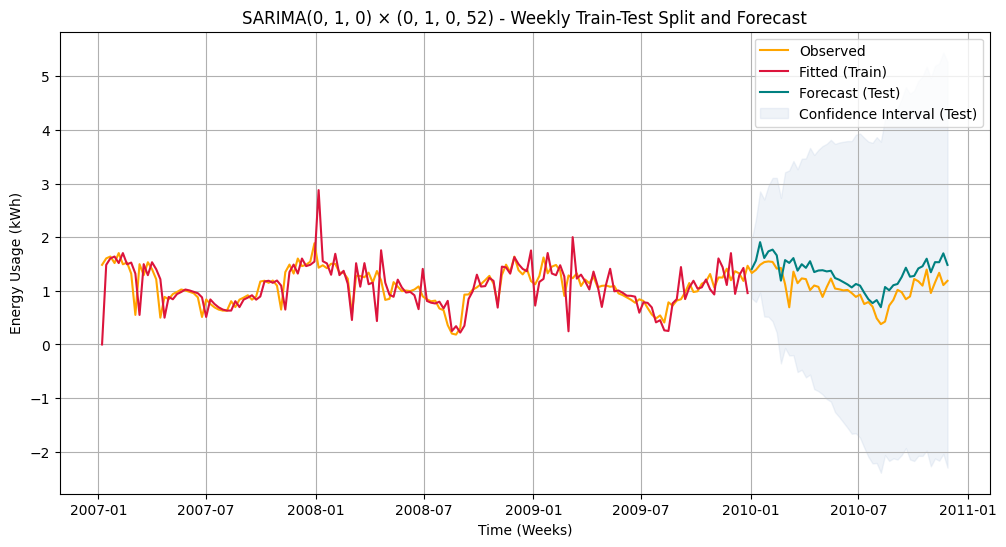

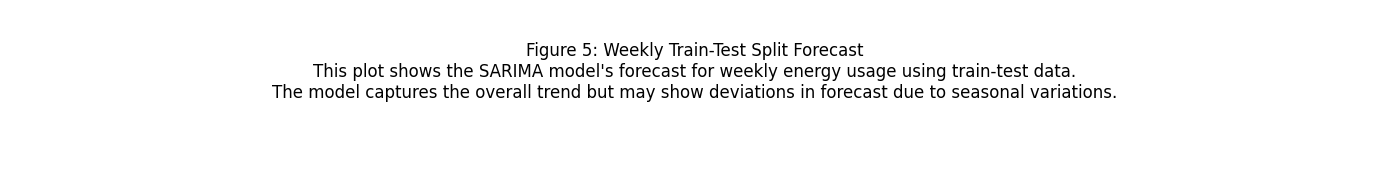

Simplified SARIMA Model Summary (Full Weekly Dataset):
                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                  204
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -14.451
Date:                            Sat, 04 Jan 2025   AIC                             30.901
Time:                                    18:53:55   BIC                             33.912
Sample:                                01-07-2007   HQIC                            32.124
                                     - 11-28-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0710      0.006     12.423      0.000     

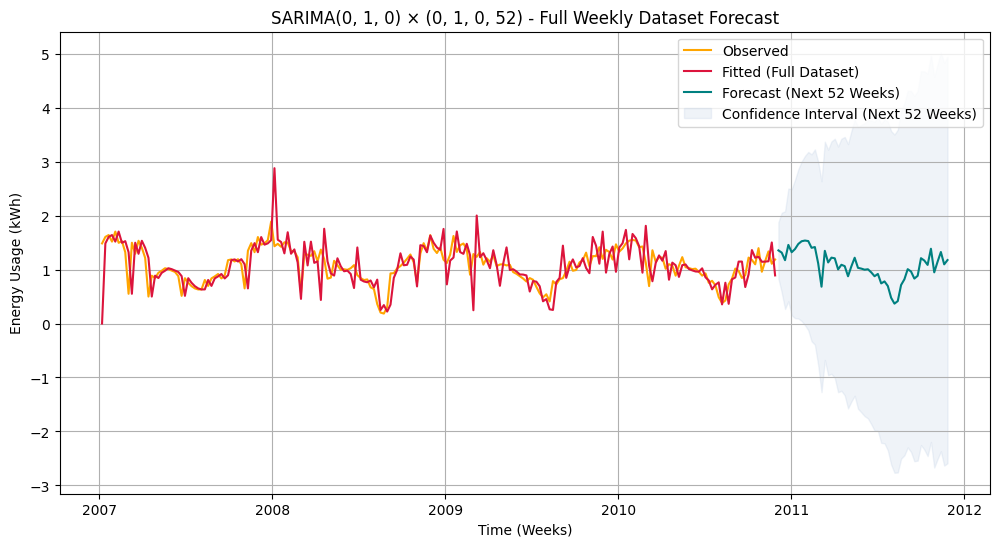

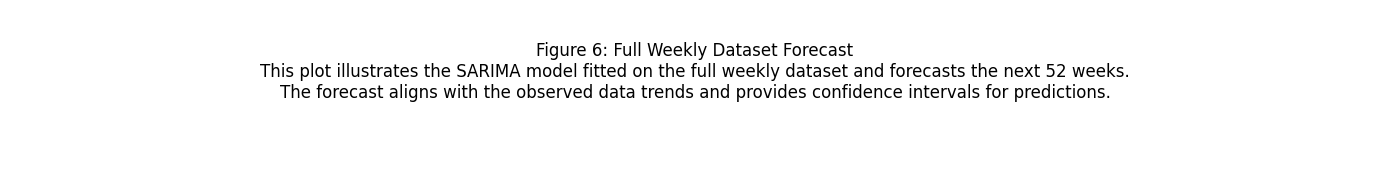

In [19]:
# Suppress warnings
warnings.filterwarnings("ignore")  # Suppress warnings to clean up output for better readability

# Define distinct colors for weekly and monthly
colors = {
    'monthly': {  # Define colors specific to monthly data visualization
        'observed': 'brown',  # Color for observed series
        'fitted': 'blue',  # Color for fitted values
        'forecast': 'green',  # Color for forecast values
        'confidence_interval': 'skyblue',  # Color for confidence intervals
    },
    'weekly': {  # Define colors specific to weekly data visualization
        'observed': 'orange',  # Color for observed series
        'fitted': 'Crimson',  # Color for fitted values
        'forecast': 'teal',  # Color for forecast values
        'confidence_interval': 'lightsteelblue',  # Color for confidence intervals
    },
}

# Step 1: Split the Weekly Data
train_data_weekly = weekly_energy_mean['2007':'2009']  # Select weekly data from 2007 to 2009 as training data
test_data_weekly = weekly_energy_mean['2010':'2011']  # Select weekly data from 2010 to 2011 as test data

# Step 2: Fit the SARIMA Model on Weekly Training Data
simpler_model_weekly_train = SARIMAX(
    train_data_weekly,  # Use training data for model fitting
    order=(0, 1, 0),  # Define non-seasonal ARIMA order (p, d, q)
    seasonal_order=(0, 1, 0, 52),  # Define seasonal ARIMA order (P, D, Q, s) with seasonality of 52 weeks
    enforce_stationarity=False,  # Allow non-stationary processes
    enforce_invertibility=False  # Allow non-invertible processes
).fit()  # Fit the SARIMA model

# Print the model summary for reference
print("Simplified SARIMA Model Summary (Weekly Train-Test):")
print(simpler_model_weekly_train.summary())  # Print the SARIMA model's summary details

# Step 3: Forecast on the Weekly Test Period
forecast_steps_test_weekly = len(test_data_weekly)  # Determine the number of steps for forecasting
forecast_weekly_test = simpler_model_weekly_train.get_forecast(steps=forecast_steps_test_weekly)  # Generate forecasts
forecast_weekly_test_mean = forecast_weekly_test.predicted_mean  # Extract predicted mean values
forecast_weekly_test_ci = forecast_weekly_test.conf_int()  # Extract confidence intervals for the forecast

# Step 4: Evaluate Weekly Model Performance on Test Data
mae_weekly_test = mean_absolute_error(test_data_weekly, forecast_weekly_test_mean)  # Calculate MAE for test data
rmse_weekly_test = np.sqrt(mean_squared_error(test_data_weekly, forecast_weekly_test_mean))  # Calculate RMSE for test data

# Print model evaluation metrics
print(f"Weekly Train-Test Mean Absolute Error (MAE): {mae_weekly_test}")
print(f"Weekly Train-Test Root Mean Squared Error (RMSE): {rmse_weekly_test}")

# Step 5: Visualize Weekly Train-Test Results
plt.figure(figsize=(12, 6))  # Set the figure size for visualization
plt.plot(weekly_energy_mean, label='Observed', color=colors['weekly']['observed'])  # Plot observed data
plt.plot(simpler_model_weekly_train.fittedvalues, label='Fitted (Train)', color=colors['weekly']['fitted'])  # Plot fitted values
plt.plot(forecast_weekly_test_mean.index, forecast_weekly_test_mean, label='Forecast (Test)', color=colors['weekly']['forecast'])  # Plot forecasted values
plt.fill_between(
    forecast_weekly_test_ci.index,
    forecast_weekly_test_ci.iloc[:, 0],  # Lower bound of confidence interval
    forecast_weekly_test_ci.iloc[:, 1],  # Upper bound of confidence interval
    color=colors['weekly']['confidence_interval'], alpha=0.2, label='Confidence Interval (Test)'
)  # Add shaded confidence interval
plt.title('SARIMA(0, 1, 0) × (0, 1, 0, 52) - Weekly Train-Test Split and Forecast')  # Add plot title
plt.xlabel('Time (Weeks)')  # Label for x-axis
plt.ylabel('Energy Usage (kWh)')  # Label for y-axis
plt.legend()  # Add legend for clarity
plt.grid()  # Add grid for better visualization
plt.show()  # Display the plot

# Add description for the plot
fig = plt.figure(figsize=(14, 2))  # Set figure size for the description
fig.text(
    0.5, 0.5,
    "Figure 5: Weekly Train-Test Split Forecast\n"
    "This plot shows the SARIMA model's forecast for weekly energy usage using train-test data.\n"
    "The model captures the overall trend but may show deviations in forecast due to seasonal variations.",
    wrap=True, horizontalalignment='center', fontsize=12  # Add text description
)
plt.axis('off')  # Turn off axis for text-only description
plt.tight_layout()  # Adjust layout
plt.show()  # Display the description

# Step 6: Fit the SARIMA Model on the Full Weekly Dataset
simpler_model_weekly_full = SARIMAX(
    weekly_energy_mean,  # Use the full dataset for training
    order=(0, 1, 0),  # Non-seasonal ARIMA order
    seasonal_order=(0, 1, 0, 52),  # Seasonal ARIMA order with 52-week seasonality
    enforce_stationarity=False,  # Allow non-stationary processes
    enforce_invertibility=False  # Allow non-invertible processes
).fit()  # Fit the SARIMA model

# Print the model summary
print("Simplified SARIMA Model Summary (Full Weekly Dataset):")
print(simpler_model_weekly_full.summary())  # Display model summary

# Step 7: Forecast the Next 52 Weeks on Full Weekly Dataset
forecast_steps_full_weekly = 52  # Set forecast horizon to 52 weeks
forecast_weekly_full = simpler_model_weekly_full.get_forecast(steps=forecast_steps_full_weekly)  # Generate forecasts
forecast_weekly_full_mean = forecast_weekly_full.predicted_mean  # Extract forecasted mean values
forecast_weekly_full_ci = forecast_weekly_full.conf_int()  # Extract confidence intervals

# Step 8: Evaluate Weekly Model Performance on Full Dataset
mae_weekly_full = mean_absolute_error(weekly_energy_mean, simpler_model_weekly_full.fittedvalues)  # Calculate MAE
rmse_weekly_full = np.sqrt(mean_squared_error(weekly_energy_mean, simpler_model_weekly_full.fittedvalues))  # Calculate RMSE

# Print evaluation metrics
print(f"Weekly Full Dataset Mean Absolute Error (MAE): {mae_weekly_full}")
print(f"Weekly Full Dataset Root Mean Squared Error (RMSE): {rmse_weekly_full}")

# Step 9: Visualize Weekly Full Dataset Forecast
plt.figure(figsize=(12, 6))  # Set the figure size for visualization
plt.plot(weekly_energy_mean, label='Observed', color=colors['weekly']['observed'])  # Plot observed data
plt.plot(simpler_model_weekly_full.fittedvalues, label='Fitted (Full Dataset)', color=colors['weekly']['fitted'])  # Plot fitted values
plt.plot(forecast_weekly_full_mean.index, forecast_weekly_full_mean, label='Forecast (Next 52 Weeks)', color=colors['weekly']['forecast'])  # Plot forecasted values
plt.fill_between(
    forecast_weekly_full_ci.index,
    forecast_weekly_full_ci.iloc[:, 0],  # Lower bound of confidence interval
    forecast_weekly_full_ci.iloc[:, 1],  # Upper bound of confidence interval
    color=colors['weekly']['confidence_interval'], alpha=0.2, label='Confidence Interval (Next 52 Weeks)'
)  # Add shaded confidence interval
plt.title('SARIMA(0, 1, 0) × (0, 1, 0, 52) - Full Weekly Dataset Forecast')  # Add plot title
plt.xlabel('Time (Weeks)')  # Label for x-axis
plt.ylabel('Energy Usage (kWh)')  # Label for y-axis
plt.legend()  # Add legend for clarity
plt.grid()  # Add grid for better visualization
plt.show()  # Display the plot

# Add description for the plot
fig = plt.figure(figsize=(14, 2))  # Set figure size for the description
fig.text(
    0.5, 0.5,
    "Figure 6: Full Weekly Dataset Forecast\n"
    "This plot illustrates the SARIMA model fitted on the full weekly dataset and forecasts the next 52 weeks.\n"
    "The forecast aligns with the observed data trends and provides confidence intervals for predictions.",
    wrap=True, horizontalalignment='center', fontsize=12  # Add text description
)
plt.axis('off')  # Turn off axis for text-only description
plt.tight_layout()  # Adjust layout
plt.show()  # Display the description


Simplified SARIMA Model Summary (Monthly Train-Test):
                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  -2.892
Date:                            Sat, 04 Jan 2025   AIC                              7.784
Time:                                    18:53:56   BIC                              8.875
Sample:                                01-31-2007   HQIC                             8.041
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0762      0.022      3.432      0.001      

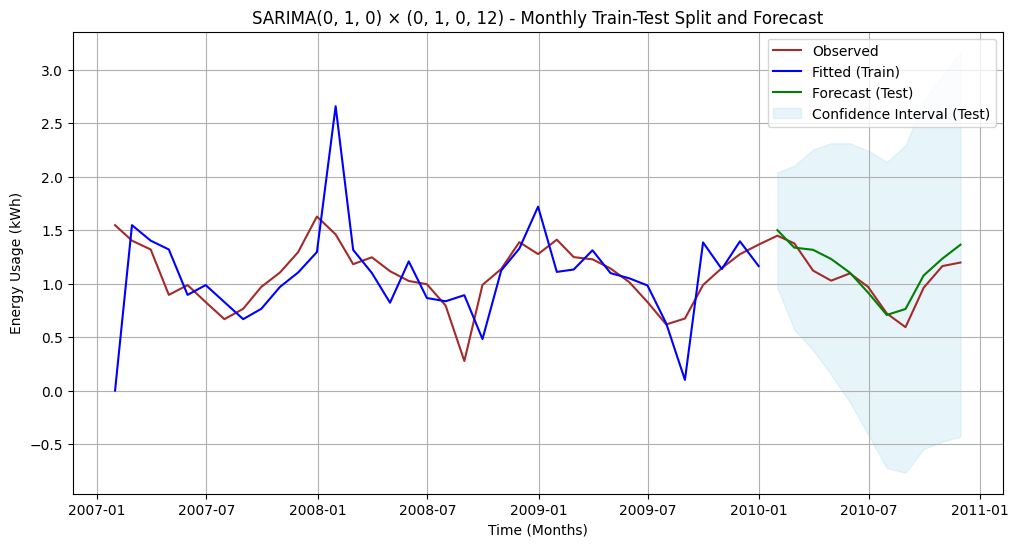

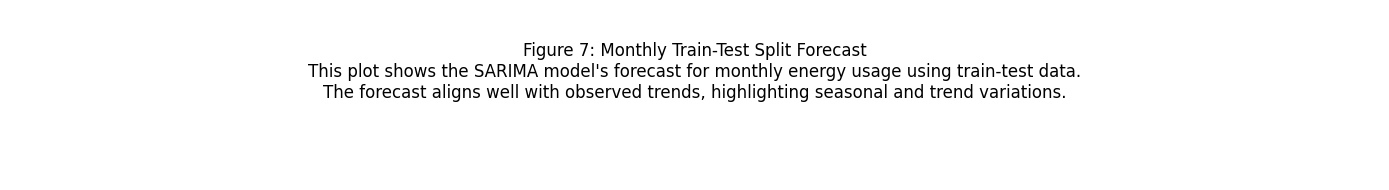

Simplified SARIMA Model Summary (Full Monthly Dataset):
                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                   47
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   0.869
Date:                            Sat, 04 Jan 2025   AIC                              0.261
Time:                                    18:53:57   BIC                              1.758
Sample:                                01-31-2007   HQIC                             0.765
                                     - 11-30-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0555      0.011      4.970      0.000    

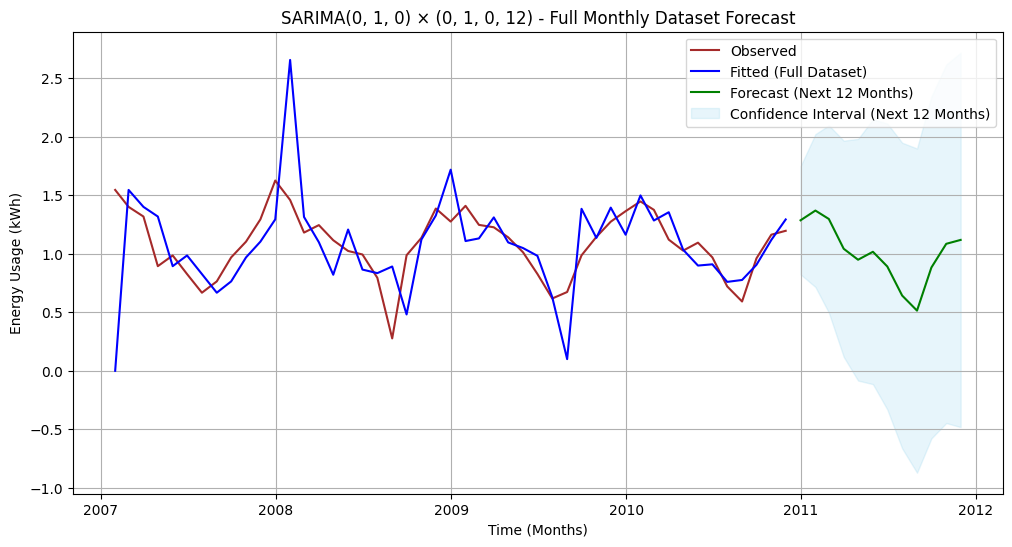

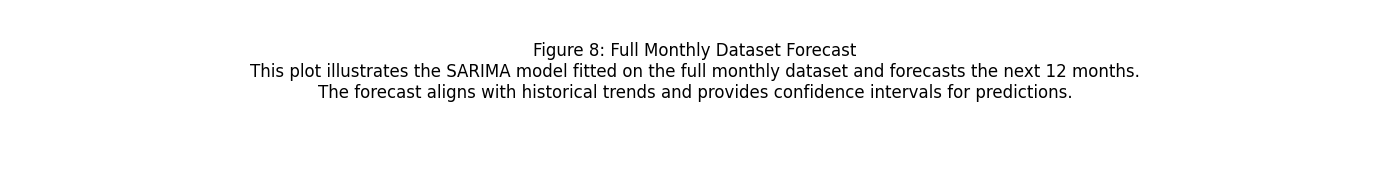

In [20]:
# Step 1: Split the Monthly Data
train_data_monthly = monthly_energy_mean['2007':'2009']  # Select monthly data from 2007 to 2009 for training
test_data_monthly = monthly_energy_mean['2010':'2011']  # Select monthly data from 2010 to 2011 for testing

# Step 2: Fit the SARIMA Model on Monthly Training Data
simpler_model_monthly_train = SARIMAX(
    train_data_monthly,  # Training data for fitting the model
    order=(0, 1, 0),  # Non-seasonal ARIMA parameters: p=0, d=1, q=0
    seasonal_order=(0, 1, 0, 12),  # Seasonal ARIMA parameters: P=0, D=1, Q=0, seasonal frequency=12 (months)
    enforce_stationarity=False,  # Allow non-stationary data without forcing stationarity
    enforce_invertibility=False  # Allow non-invertible models for flexibility
).fit()  # Fit the SARIMA model

# Print the model summary to analyze fitted parameters and statistics
print("Simplified SARIMA Model Summary (Monthly Train-Test):")
print(simpler_model_monthly_train.summary())

# Step 3: Forecast on the Monthly Test Period
forecast_steps_test_monthly = len(test_data_monthly)  # Determine the number of months to forecast based on test data length
forecast_monthly_test = simpler_model_monthly_train.get_forecast(steps=forecast_steps_test_monthly)  # Generate forecasts
forecast_monthly_test_mean = forecast_monthly_test.predicted_mean  # Extract predicted mean values for the forecast
forecast_monthly_test_ci = forecast_monthly_test.conf_int()  # Extract confidence intervals for the forecast

# Step 4: Evaluate Monthly Model Performance on Test Data
mae_monthly_test = mean_absolute_error(test_data_monthly, forecast_monthly_test_mean)  # Calculate MAE for test data
rmse_monthly_test = np.sqrt(mean_squared_error(test_data_monthly, forecast_monthly_test_mean))  # Calculate RMSE for test data

# Print the evaluation metrics to assess model performance
print(f"Monthly Train-Test Mean Absolute Error (MAE): {mae_monthly_test}")
print(f"Monthly Train-Test Root Mean Squared Error (RMSE): {rmse_monthly_test}")

# Step 5: Visualize Monthly Train-Test Results
plt.figure(figsize=(12, 6))  # Set the figure size for the plot
plt.plot(monthly_energy_mean, label='Observed', color=colors['monthly']['observed'])  # Plot the observed data
plt.plot(simpler_model_monthly_train.fittedvalues, label='Fitted (Train)', color=colors['monthly']['fitted'])  # Plot the fitted values from the model
plt.plot(forecast_monthly_test_mean.index, forecast_monthly_test_mean, label='Forecast (Test)', color=colors['monthly']['forecast'])  # Plot the forecasted values
plt.fill_between(
    forecast_monthly_test_ci.index,  # X-axis range for the confidence interval
    forecast_monthly_test_ci.iloc[:, 0],  # Lower bound of the confidence interval
    forecast_monthly_test_ci.iloc[:, 1],  # Upper bound of the confidence interval
    color=colors['monthly']['confidence_interval'], alpha=0.2, label='Confidence Interval (Test)'  # Fill the confidence interval area
)
plt.title('SARIMA(0, 1, 0) × (0, 1, 0, 12) - Monthly Train-Test Split and Forecast')  # Add a title to the plot
plt.xlabel('Time (Months)')  # Label the x-axis
plt.ylabel('Energy Usage (kWh)')  # Label the y-axis
plt.legend()  # Add a legend to distinguish data series
plt.grid()  # Add grid lines to the plot for better readability
plt.show()  # Display the plot

# Add description for the plot to provide insights
fig = plt.figure(figsize=(14, 2))  # Create a figure for the description
fig.text(
    0.5, 0.5,
    "Figure 7: Monthly Train-Test Split Forecast\n"
    "This plot shows the SARIMA model's forecast for monthly energy usage using train-test data.\n"
    "The forecast aligns well with observed trends, highlighting seasonal and trend variations.",
    wrap=True, horizontalalignment='center', fontsize=12  # Format the description
)
plt.axis('off')  # Hide axes for the description figure
plt.tight_layout()  # Adjust layout to fit text
plt.show()  # Display the description

# Step 6: Fit the SARIMA Model on the Full Monthly Dataset
simpler_model_monthly_full = SARIMAX(
    monthly_energy_mean,  # Full dataset for fitting the model
    order=(0, 1, 0),  # Non-seasonal ARIMA parameters: p=0, d=1, q=0
    seasonal_order=(0, 1, 0, 12),  # Seasonal ARIMA parameters: P=0, D=1, Q=0, seasonal frequency=12 (months)
    enforce_stationarity=False,  # Allow non-stationary data without forcing stationarity
    enforce_invertibility=False  # Allow non-invertible models for flexibility
).fit()  # Fit the SARIMA model

# Print the model summary for analysis
print("Simplified SARIMA Model Summary (Full Monthly Dataset):")
print(simpler_model_monthly_full.summary())

# Step 7: Forecast the Next 12 Months on Full Monthly Dataset
forecast_steps_full_monthly = 12  # Set the forecast horizon to 12 months
forecast_monthly_full = simpler_model_monthly_full.get_forecast(steps=forecast_steps_full_monthly)  # Generate forecasts
forecast_monthly_full_mean = forecast_monthly_full.predicted_mean  # Extract forecasted mean values
forecast_monthly_full_ci = forecast_monthly_full.conf_int()  # Extract confidence intervals for the forecast

# Step 8: Evaluate Monthly Model Performance on Full Dataset
mae_monthly_full = mean_absolute_error(monthly_energy_mean, simpler_model_monthly_full.fittedvalues)  # Calculate MAE for full dataset
rmse_monthly_full = np.sqrt(mean_squared_error(monthly_energy_mean, simpler_model_monthly_full.fittedvalues))  # Calculate RMSE for full dataset

# Print evaluation metrics for the full dataset
print(f"Monthly Full Dataset Mean Absolute Error (MAE): {mae_monthly_full}")
print(f"Monthly Full Dataset Root Mean Squared Error (RMSE): {rmse_monthly_full}")

# Step 9: Visualize Monthly Full Dataset Forecast
plt.figure(figsize=(12, 6))  # Set the figure size for the plot
plt.plot(monthly_energy_mean, label='Observed', color=colors['monthly']['observed'])  # Plot the observed data
plt.plot(simpler_model_monthly_full.fittedvalues, label='Fitted (Full Dataset)', color=colors['monthly']['fitted'])  # Plot fitted values
plt.plot(forecast_monthly_full_mean.index, forecast_monthly_full_mean, label='Forecast (Next 12 Months)', color=colors['monthly']['forecast'])  # Plot the forecast
plt.fill_between(
    forecast_monthly_full_ci.index,  # X-axis range for the confidence interval
    forecast_monthly_full_ci.iloc[:, 0],  # Lower bound of the confidence interval
    forecast_monthly_full_ci.iloc[:, 1],  # Upper bound of the confidence interval
    color=colors['monthly']['confidence_interval'], alpha=0.2, label='Confidence Interval (Next 12 Months)'  # Fill the confidence interval area
)
plt.title('SARIMA(0, 1, 0) × (0, 1, 0, 12) - Full Monthly Dataset Forecast')  # Add a title to the plot
plt.xlabel('Time (Months)')  # Label the x-axis
plt.ylabel('Energy Usage (kWh)')  # Label the y-axis
plt.legend()  # Add a legend to distinguish data series
plt.grid()  # Add grid lines to the plot for better readability
plt.show()  # Display the plot

# Add description for the plot to provide insights
fig = plt.figure(figsize=(14, 2))  # Create a figure for the description
fig.text(
    0.5, 0.5,
    "Figure 8: Full Monthly Dataset Forecast\n"
    "This plot illustrates the SARIMA model fitted on the full monthly dataset and forecasts the next 12 months.\n"
    "The forecast aligns with historical trends and provides confidence intervals for predictions.",
    wrap=True, horizontalalignment='center', fontsize=12  # Format the description
)
plt.axis('off')  # Hide axes for the description figure
plt.tight_layout()  # Adjust layout to fit text
plt.show()  # Display the description


6. Residual Analysis and Performance Evaluation

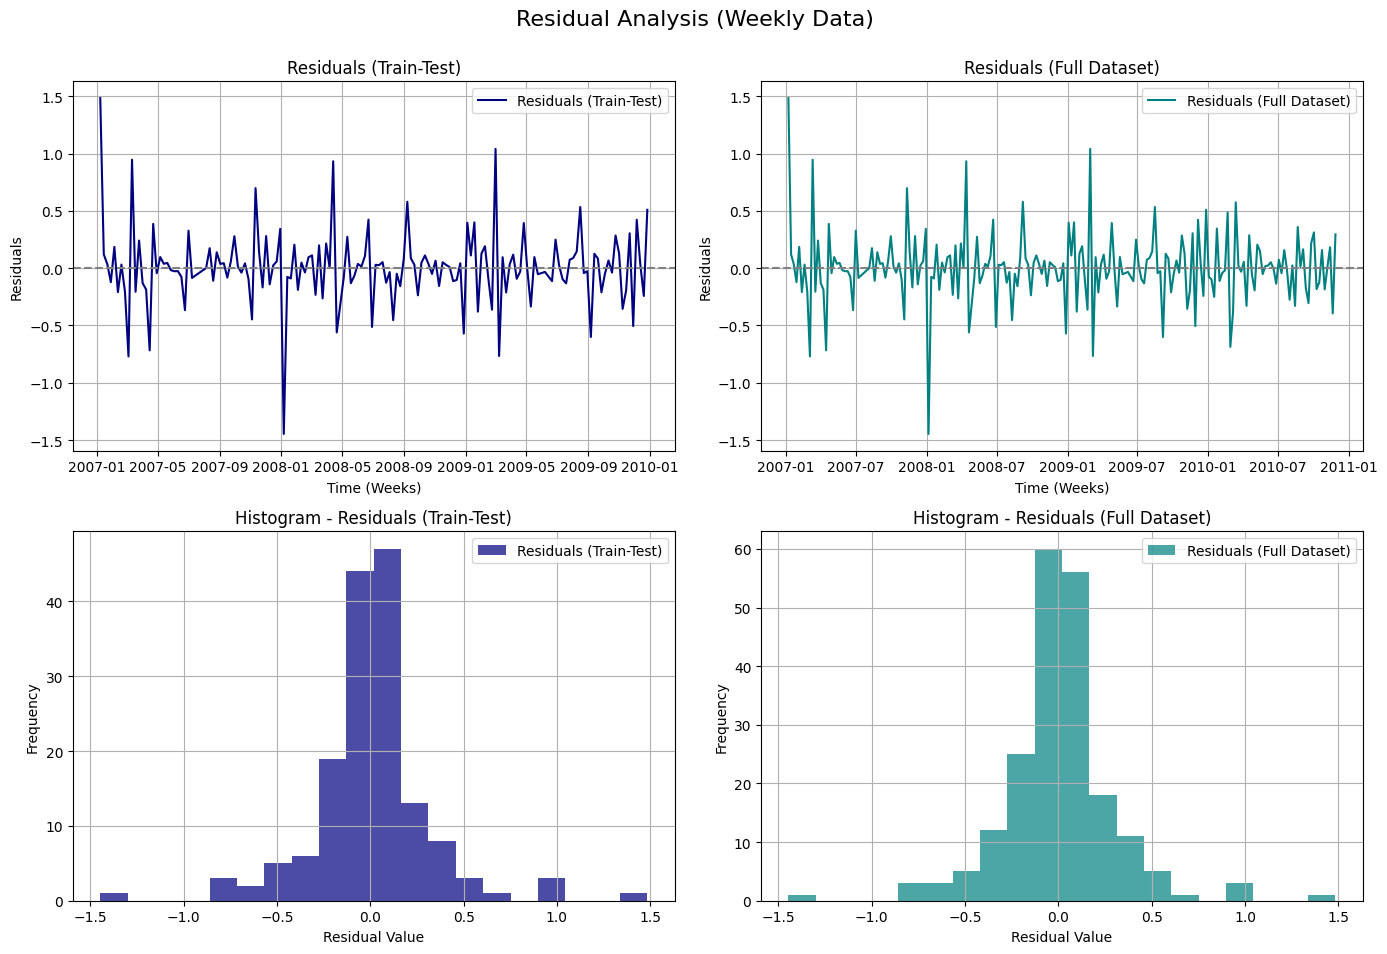

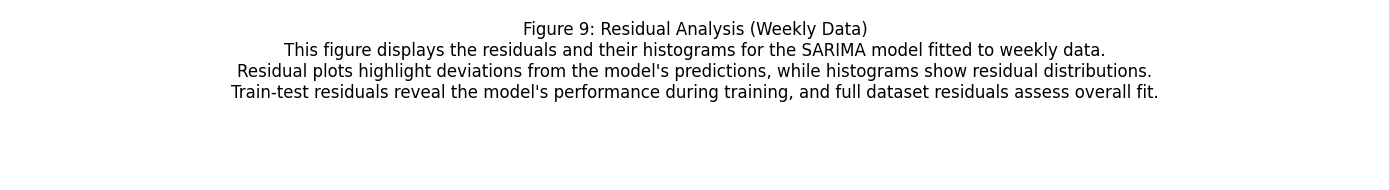

In [21]:
# Step 10: Residual Analysis
# Residuals for Train-Test Model
residuals_train_weekly = simpler_model_weekly_train.resid  # Extract residuals from the SARIMA model trained on weekly training data
residuals_full_weekly = simpler_model_weekly_full.resid  # Extract residuals from the SARIMA model trained on the full weekly dataset

# Define colors for residual plots
colors = {  # Define a dictionary to store colors for visual consistency
    'monthly': {  # Colors specific to monthly residual analysis
        'residual_train': 'purple',  # Color for train-test residuals
        'residual_full': 'orange',  # Color for full dataset residuals
        'hist_train': 'purple',  # Color for histogram of train-test residuals
        'hist_full': 'orange',  # Color for histogram of full dataset residuals
    },
    'weekly': {  # Colors specific to weekly residual analysis
        'residual_train': 'navy',  # Color for train-test residuals
        'residual_full': 'teal',  # Color for full dataset residuals
        'hist_train': 'navy',  # Color for histogram of train-test residuals
        'hist_full': 'teal',  # Color for histogram of full dataset residuals
    }
}

# Residual Analysis for Weekly Data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create a 2x2 grid of subplots with a figure size of 14x10 inches
fig.suptitle("Residual Analysis (Weekly Data)", fontsize=16, y=0.95)  # Add a title to the figure with custom font size and position

# Residual Plot for Train-Test Model
axes[0, 0].plot(residuals_train_weekly, label='Residuals (Train-Test)', color=colors['weekly']['residual_train'])  # Plot residuals for the train-test model
axes[0, 0].axhline(0, linestyle='--', color='gray')  # Add a horizontal line at y=0 as a reference point
axes[0, 0].set_title('Residuals (Train-Test)')  # Add a title to the subplot
axes[0, 0].set_xlabel('Time (Weeks)')  # Label the x-axis
axes[0, 0].set_ylabel('Residuals')  # Label the y-axis
axes[0, 0].legend()  # Add a legend for the plot
axes[0, 0].grid()  # Add grid lines for easier interpretation

# Residual Plot for Full Dataset Model
axes[0, 1].plot(residuals_full_weekly, label='Residuals (Full Dataset)', color=colors['weekly']['residual_full'])  # Plot residuals for the full dataset model
axes[0, 1].axhline(0, linestyle='--', color='gray')  # Add a horizontal line at y=0 for reference
axes[0, 1].set_title('Residuals (Full Dataset)')  # Add a title to the subplot
axes[0, 1].set_xlabel('Time (Weeks)')  # Label the x-axis
axes[0, 1].set_ylabel('Residuals')  # Label the y-axis
axes[0, 1].legend()  # Add a legend for the plot
axes[0, 1].grid()  # Add grid lines for better readability

# Histogram of Residuals (Train-Test)
axes[1, 0].hist(residuals_train_weekly, bins=20, color=colors['weekly']['hist_train'], alpha=0.7, label='Residuals (Train-Test)')  # Plot a histogram of train-test residuals
axes[1, 0].set_title('Histogram - Residuals (Train-Test)')  # Add a title to the subplot
axes[1, 0].set_xlabel('Residual Value')  # Label the x-axis
axes[1, 0].set_ylabel('Frequency')  # Label the y-axis
axes[1, 0].legend()  # Add a legend for the plot
axes[1, 0].grid()  # Add grid lines for easier interpretation

# Histogram of Residuals (Full Dataset)
axes[1, 1].hist(residuals_full_weekly, bins=20, color=colors['weekly']['hist_full'], alpha=0.7, label='Residuals (Full Dataset)')  # Plot a histogram of full dataset residuals
axes[1, 1].set_title('Histogram - Residuals (Full Dataset)')  # Add a title to the subplot
axes[1, 1].set_xlabel('Residual Value')  # Label the x-axis
axes[1, 1].set_ylabel('Frequency')  # Label the y-axis
axes[1, 1].legend()  # Add a legend for the plot
axes[1, 1].grid()  # Add grid lines for better readability

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to prevent overlapping and allocate space for the title
plt.show()  # Display the figure

# Add description for the plot
fig = plt.figure(figsize=(14, 2))  # Create a new figure for adding a text description
fig.text(
    0.5, 0.5,  # Position of the text (centered)
    "Figure 9: Residual Analysis (Weekly Data)\n"
    "This figure displays the residuals and their histograms for the SARIMA model fitted to weekly data.\n"
    "Residual plots highlight deviations from the model's predictions, while histograms show residual distributions.\n"
    "Train-test residuals reveal the model's performance during training, and full dataset residuals assess overall fit.",
    wrap=True, horizontalalignment='center', fontsize=12  # Wrap text and align it horizontally in the center
)
plt.axis('off')  # Hide axes for the description figure
plt.tight_layout()  # Adjust layout for better alignment
plt.show()  # Display the description


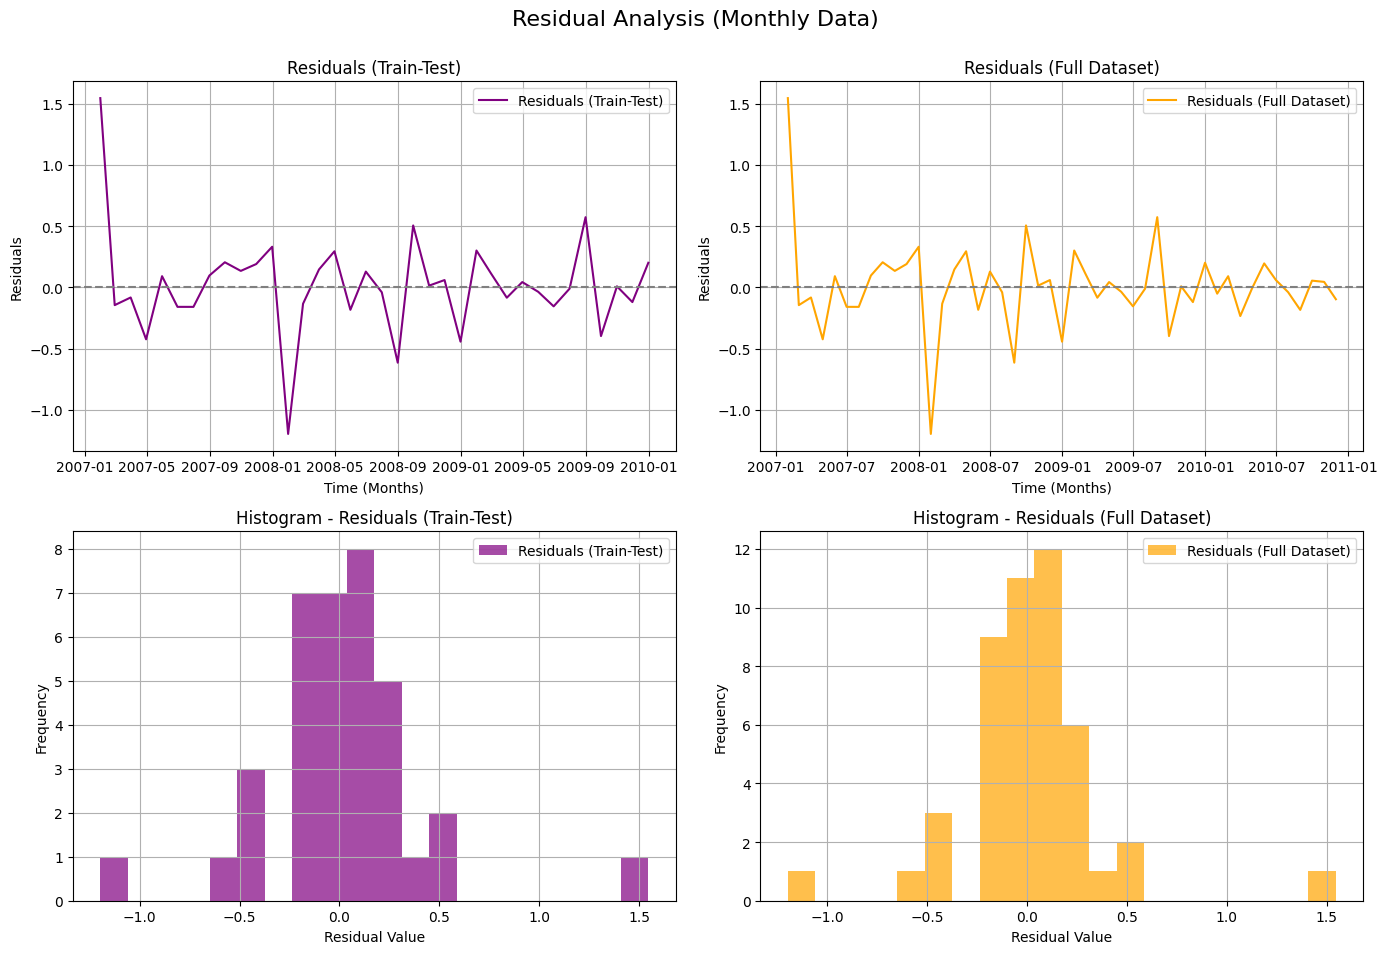

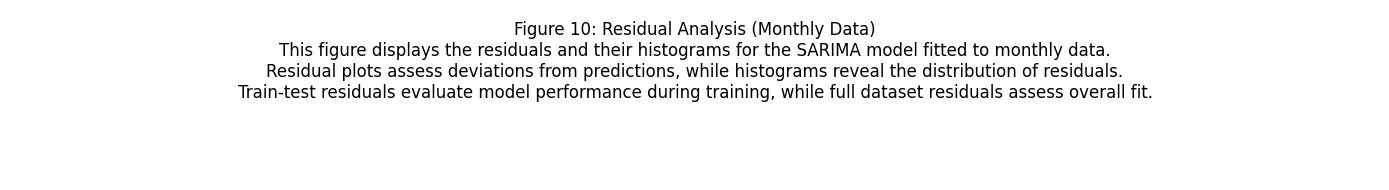

In [22]:
# Residuals for Train-Test Model
residuals_train_monthly = simpler_model_monthly_train.resid  # Extract residuals from the SARIMA model trained on monthly training data
residuals_full_monthly = simpler_model_monthly_full.resid  # Extract residuals from the SARIMA model trained on the full monthly dataset

# Residual Analysis for Monthly Data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create a 2x2 grid of subplots with a figure size of 14x10 inches
fig.suptitle("Residual Analysis (Monthly Data)", fontsize=16, y=0.95)  # Add a title to the entire figure

# Residual Plot for Train-Test Model
axes[0, 0].plot(residuals_train_monthly, label='Residuals (Train-Test)', color=colors['monthly']['residual_train'])  # Plot train-test residuals
axes[0, 0].axhline(0, linestyle='--', color='gray')  # Add a horizontal line at y=0 for reference
axes[0, 0].set_title('Residuals (Train-Test)')  # Set the title for the subplot
axes[0, 0].set_xlabel('Time (Months)')  # Label the x-axis
axes[0, 0].set_ylabel('Residuals')  # Label the y-axis
axes[0, 0].legend()  # Add a legend to the subplot
axes[0, 0].grid()  # Add gridlines for better readability

# Residual Plot for Full Dataset Model
axes[0, 1].plot(residuals_full_monthly, label='Residuals (Full Dataset)', color=colors['monthly']['residual_full'])  # Plot full dataset residuals
axes[0, 1].axhline(0, linestyle='--', color='gray')  # Add a horizontal line at y=0 for reference
axes[0, 1].set_title('Residuals (Full Dataset)')  # Set the title for the subplot
axes[0, 1].set_xlabel('Time (Months)')  # Label the x-axis
axes[0, 1].set_ylabel('Residuals')  # Label the y-axis
axes[0, 1].legend()  # Add a legend to the subplot
axes[0, 1].grid()  # Add gridlines for better readability

# Histogram of Residuals (Train-Test)
axes[1, 0].hist(residuals_train_monthly, bins=20, color=colors['monthly']['hist_train'], alpha=0.7, label='Residuals (Train-Test)')  # Plot histogram of train-test residuals
axes[1, 0].set_title('Histogram - Residuals (Train-Test)')  # Set the title for the subplot
axes[1, 0].set_xlabel('Residual Value')  # Label the x-axis
axes[1, 0].set_ylabel('Frequency')  # Label the y-axis
axes[1, 0].legend()  # Add a legend to the subplot
axes[1, 0].grid()  # Add gridlines for better readability

# Histogram of Residuals (Full Dataset)
axes[1, 1].hist(residuals_full_monthly, bins=20, color=colors['monthly']['hist_full'], alpha=0.7, label='Residuals (Full Dataset)')  # Plot histogram of full dataset residuals
axes[1, 1].set_title('Histogram - Residuals (Full Dataset)')  # Set the title for the subplot
axes[1, 1].set_xlabel('Residual Value')  # Label the x-axis
axes[1, 1].set_ylabel('Frequency')  # Label the y-axis
axes[1, 1].legend()  # Add a legend to the subplot
axes[1, 1].grid()  # Add gridlines for better readability

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlapping elements and set space for the title
plt.show()  # Display the plots

# Add description for Monthly Data Residual Analysis
fig = plt.figure(figsize=(14, 2))  # Create a new figure for the description
fig.text(
    0.5, 0.5,
    "Figure 10: Residual Analysis (Monthly Data)\n"
    "This figure displays the residuals and their histograms for the SARIMA model fitted to monthly data.\n"
    "Residual plots assess deviations from predictions, while histograms reveal the distribution of residuals.\n"
    "Train-test residuals evaluate model performance during training, while full dataset residuals assess overall fit.",
    wrap=True, horizontalalignment='center', fontsize=12
)
plt.axis('off')  # Hide axes for the text description
plt.tight_layout()  # Adjust layout for better alignment
plt.show()

7. Autocorrelation Analysis

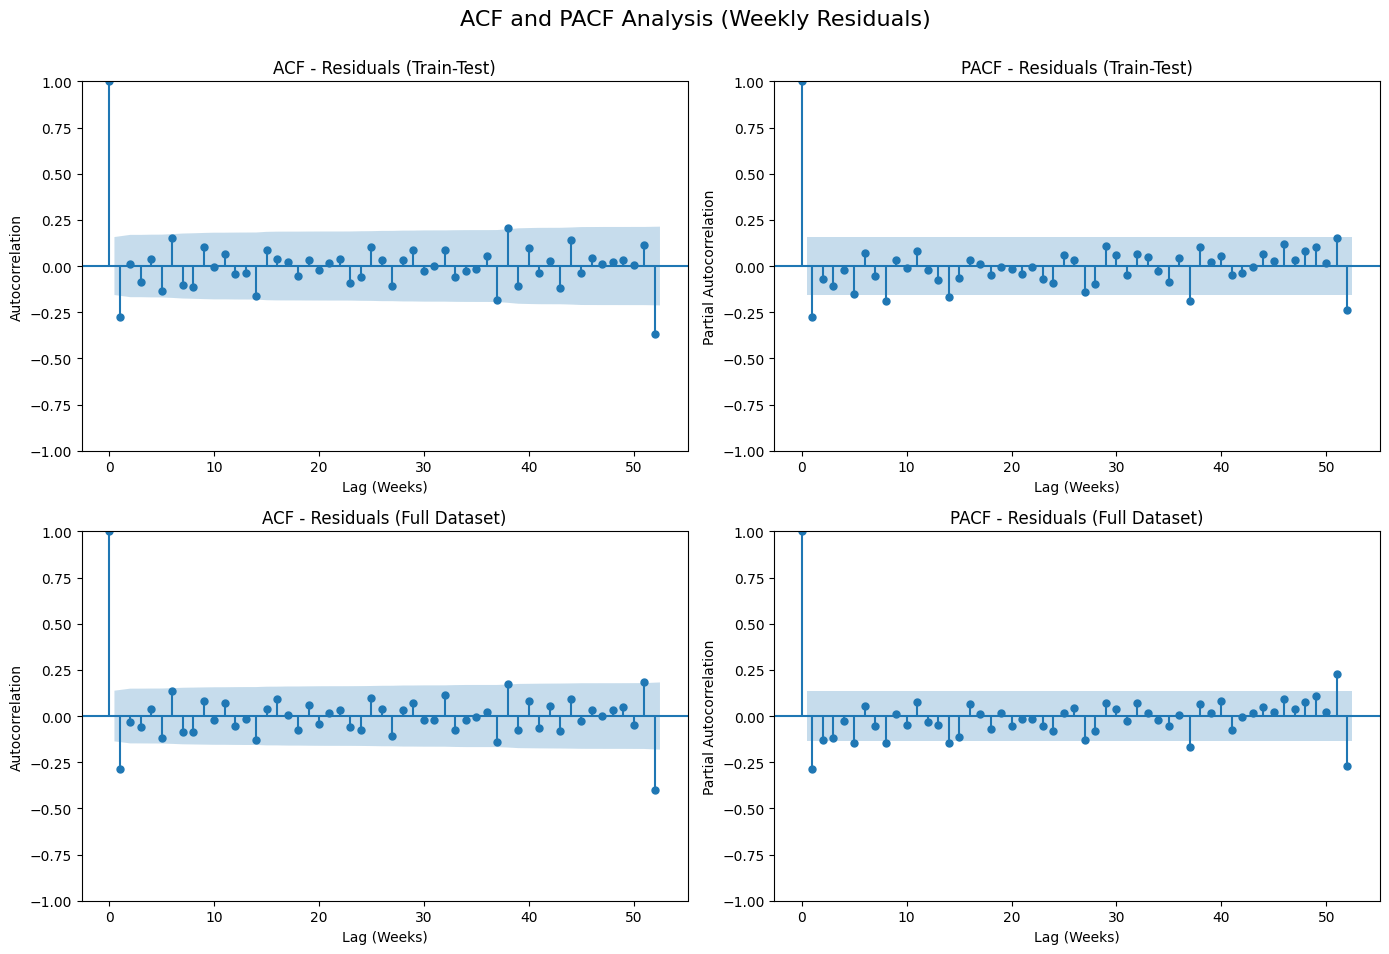

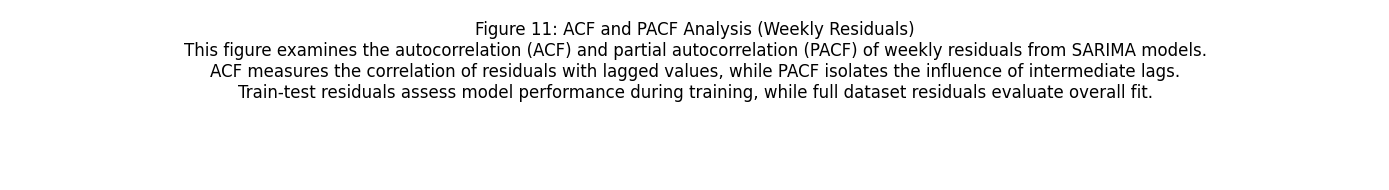

In [23]:
# Calculate maximum allowable lags for PACF (50% of the residual sample size)
max_lags_train = min(52, len(residuals_train_weekly) // 2)  # Determine maximum lags for PACF for train-test residuals, capped at 52
max_lags_full = min(52, len(residuals_full_weekly) // 2)  # Determine maximum lags for PACF for full dataset residuals, capped at 52

# Create 2x2 subplot layout for ACF and PACF
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create a figure with 2 rows and 2 columns of subplots, set figure size to 14x10 inches
fig.suptitle("ACF and PACF Analysis (Weekly Residuals)", fontsize=16, y=0.95)  # Add a main title to the figure, slightly above the subplots

# ACF for Residuals (Train-Test)
plot_acf(residuals_train_weekly.dropna(), lags=max_lags_train, ax=axes[0, 0])  # Plot ACF for train-test residuals, using calculated lags
axes[0, 0].set_title("ACF - Residuals (Train-Test)")  # Set title for the subplot
axes[0, 0].set_xlabel("Lag (Weeks)")  # Label the x-axis to indicate lag in weeks
axes[0, 0].set_ylabel("Autocorrelation")  # Label the y-axis to indicate the autocorrelation values

# PACF for Residuals (Train-Test)
plot_pacf(residuals_train_weekly.dropna(), lags=max_lags_train, ax=axes[0, 1])  # Plot PACF for train-test residuals, using calculated lags
axes[0, 1].set_title("PACF - Residuals (Train-Test)")  # Set title for the subplot
axes[0, 1].set_xlabel("Lag (Weeks)")  # Label the x-axis to indicate lag in weeks
axes[0, 1].set_ylabel("Partial Autocorrelation")  # Label the y-axis to indicate the partial autocorrelation values

# ACF for Residuals (Full Dataset)
plot_acf(residuals_full_weekly.dropna(), lags=max_lags_full, ax=axes[1, 0])  # Plot ACF for full dataset residuals, using calculated lags
axes[1, 0].set_title("ACF - Residuals (Full Dataset)")  # Set title for the subplot
axes[1, 0].set_xlabel("Lag (Weeks)")  # Label the x-axis to indicate lag in weeks
axes[1, 0].set_ylabel("Autocorrelation")  # Label the y-axis to indicate the autocorrelation values

# PACF for Residuals (Full Dataset)
plot_pacf(residuals_full_weekly.dropna(), lags=max_lags_full, ax=axes[1, 1])  # Plot PACF for full dataset residuals, using calculated lags
axes[1, 1].set_title("PACF - Residuals (Full Dataset)")  # Set title for the subplot
axes[1, 1].set_xlabel("Lag (Weeks)")  # Label the x-axis to indicate lag in weeks
axes[1, 1].set_ylabel("Partial Autocorrelation")  # Label the y-axis to indicate the partial autocorrelation values

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to ensure subplots fit nicely without overlapping, reserve space for the title
plt.show()  # Render and display the plots

# Add description for ACF and PACF Analysis
fig = plt.figure(figsize=(14, 2))  # Create a new figure for the description
fig.text(
    0.5, 0.5,
    "Figure 11: ACF and PACF Analysis (Weekly Residuals)\n"
    "This figure examines the autocorrelation (ACF) and partial autocorrelation (PACF) of weekly residuals from SARIMA models.\n"
    "ACF measures the correlation of residuals with lagged values, while PACF isolates the influence of intermediate lags.\n"
    "Train-test residuals assess model performance during training, while full dataset residuals evaluate overall fit.",
    wrap=True, horizontalalignment='center', fontsize=12
)
plt.axis('off')  # Hide axes for the text description
plt.tight_layout()  # Adjust layout for better alignment
plt.show()


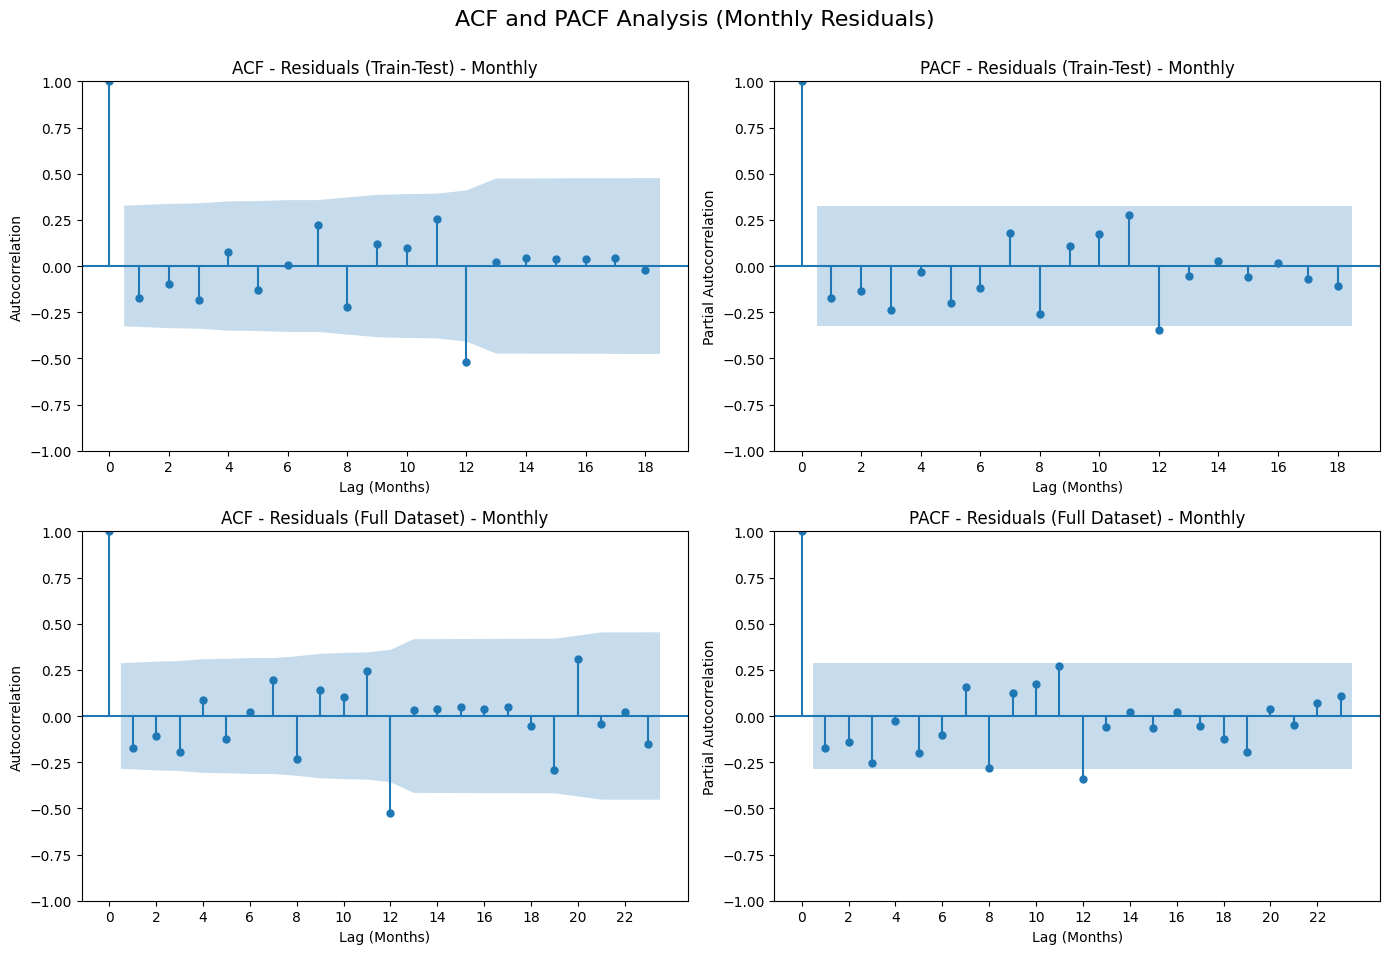

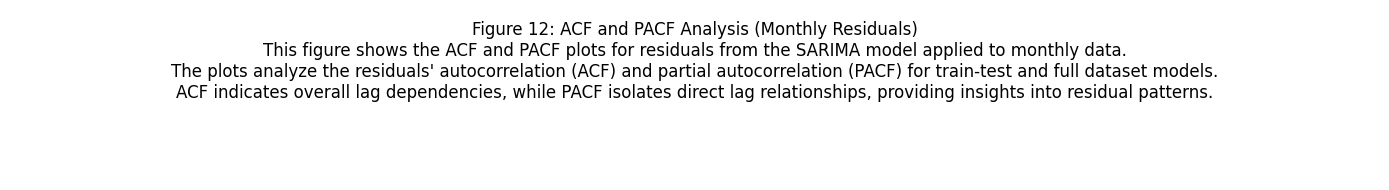

In [24]:
# Calculate maximum allowable lags for PACF (50% of the residual sample size)
max_lags_monthly_train = min(24, len(residuals_train_monthly) // 2)  # Calculate maximum lags for train-test residuals, capped at 24
max_lags_monthly_full = min(24, len(residuals_full_monthly) // 2)  # Calculate maximum lags for full dataset residuals, capped at 24

# Create 2x2 subplot layout for ACF and PACF
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create a figure with 2 rows and 2 columns of subplots, size set to 14x10 inches
fig.suptitle("ACF and PACF Analysis (Monthly Residuals)", fontsize=16, y=0.95)  # Add a main title, positioned slightly above the subplots

# ACF for Residuals (Train-Test)
plot_acf(residuals_train_monthly.dropna(), lags=max_lags_monthly_train, ax=axes[0, 0])  # Plot ACF for train-test residuals with calculated lags
axes[0, 0].set_title("ACF - Residuals (Train-Test) - Monthly")  # Set title for this subplot
axes[0, 0].set_xlabel("Lag (Months)")  # Label the x-axis to indicate lag in months
axes[0, 0].set_ylabel("Autocorrelation")  # Label the y-axis to indicate autocorrelation values
axes[0, 0].set_ylim(-1, 1)  # Set the y-axis limits for better readability of the plot
axes[0, 0].set_xticks(range(0, max_lags_monthly_train + 1, 2))  # Add ticks every 2 lags on the x-axis for clarity

# PACF for Residuals (Train-Test)
plot_pacf(residuals_train_monthly.dropna(), lags=max_lags_monthly_train, ax=axes[0, 1])  # Plot PACF for train-test residuals with calculated lags
axes[0, 1].set_title("PACF - Residuals (Train-Test) - Monthly")  # Set title for this subplot
axes[0, 1].set_xlabel("Lag (Months)")  # Label the x-axis to indicate lag in months
axes[0, 1].set_ylabel("Partial Autocorrelation")  # Label the y-axis to indicate partial autocorrelation values
axes[0, 1].set_ylim(-1, 1)  # Set the y-axis limits for better readability of the plot
axes[0, 1].set_xticks(range(0, max_lags_monthly_train + 1, 2))  # Add ticks every 2 lags on the x-axis for clarity

# ACF for Residuals (Full Dataset)
plot_acf(residuals_full_monthly.dropna(), lags=max_lags_monthly_full, ax=axes[1, 0])  # Plot ACF for full dataset residuals with calculated lags
axes[1, 0].set_title("ACF - Residuals (Full Dataset) - Monthly")  # Set title for this subplot
axes[1, 0].set_xlabel("Lag (Months)")  # Label the x-axis to indicate lag in months
axes[1, 0].set_ylabel("Autocorrelation")  # Label the y-axis to indicate autocorrelation values
axes[1, 0].set_ylim(-1, 1)  # Set the y-axis limits for better readability of the plot
axes[1, 0].set_xticks(range(0, max_lags_monthly_full + 1, 2))  # Add ticks every 2 lags on the x-axis for clarity

# PACF for Residuals (Full Dataset)
plot_pacf(residuals_full_monthly.dropna(), lags=max_lags_monthly_full, ax=axes[1, 1])  # Plot PACF for full dataset residuals with calculated lags
axes[1, 1].set_title("PACF - Residuals (Full Dataset) - Monthly")  # Set title for this subplot
axes[1, 1].set_xlabel("Lag (Months)")  # Label the x-axis to indicate lag in months
axes[1, 1].set_ylabel("Partial Autocorrelation")  # Label the y-axis to indicate partial autocorrelation values
axes[1, 1].set_ylim(-1, 1)  # Set the y-axis limits for better readability of the plot
axes[1, 1].set_xticks(range(0, max_lags_monthly_full + 1, 2))  # Add ticks every 2 lags on the x-axis for clarity

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust subplot layout to avoid overlapping, reserving space for the title
plt.show()  # Render and display the plots

# Add description for the figure
fig = plt.figure(figsize=(14, 2))  # Create a new figure for the description text
fig.text(
    0.5, 0.5,  # Position the text in the center
    "Figure 12: ACF and PACF Analysis (Monthly Residuals)\n"
    "This figure shows the ACF and PACF plots for residuals from the SARIMA model applied to monthly data.\n"
    "The plots analyze the residuals' autocorrelation (ACF) and partial autocorrelation (PACF) for train-test and full dataset models.\n"
    "ACF indicates overall lag dependencies, while PACF isolates direct lag relationships, providing insights into residual patterns.",
    wrap=True, horizontalalignment='center', fontsize=12  # Wrap text and align it horizontally in the center
)
plt.axis('off')  # Hide axes for the description figure
plt.tight_layout()  # Adjust layout for better alignment
plt.show()  # Render and display the description
